# Inerpretation-Net

## Specification of Experiment Settings

In [1]:
#######################################################################################################################################
###################################################### CONFIG FILE ####################################################################
#######################################################################################################################################
sleep_time = 0 #minutes


config = {
    'function_family': {
        'maximum_depth': 3,
        'beta': 1,
        'decision_sparsity': 1,
        'fully_grown': True,    
        'dt_type': 'SDT', #'SDT', 'vanilla'
    },
    'data': {
        'number_of_variables': 2, 
        'num_classes': 2,
        'categorical_indices': [],
        
        'use_distribution_list': True,
        'random_parameters_distribution': True, 
        'max_distributions_per_class': 1, #
        'exclude_linearly_seperable': True,
        'data_generation_filtering': False,
        'fixed_class_probability': False,
        'balanced_data': True,
        'weighted_data_generation': False,
        'shift_distrib': False,
        
        'dt_type_train': 'vanilla', # (None, 'vanilla', 'SDT')
        'maximum_depth_train': 3, #None or int
        'decision_sparsity_train': 1, #None or int
        
        'function_generation_type': 'distribution',
        'distrib_by_feature': True,
        'distribution_list': ['uniform', 'normal', 'gamma', 'beta', 'poisson'], 
        'distribution_list_eval': ['uniform', 'normal', 'gamma', 'beta', 'poisson'],
        
        'objective': 'classification', 
        
        'x_max': 1,
        'x_min': 0,
        'x_distrib': 'uniform', 
                
        'lambda_dataset_size': 5000, #number of samples per function
        'number_of_generated_datasets': 10000,
        
        'noise_injected_level': 0, 
        'noise_injected_type': 'flip_percentage', 
        
        'data_noise': 0, #None or float
        
        'distrib_param_max': 5,
    }, 
    'lambda_net': {
        'epochs_lambda': 1000,
        'early_stopping_lambda': True, 
        'early_stopping_min_delta_lambda': 1e-3,
        'restore_best_weights': True,
        'patience_lambda': 50,
        
        'batch_lambda': 64,
        'dropout_lambda': 0,
        'lambda_network_layers': [128],
        'use_batchnorm_lambda': False,
        
        'optimizer_lambda': 'adam',
        'loss_lambda': 'binary_crossentropy', 
        
        'number_of_lambda_weights': None,
        
        'number_initializations_lambda': 1, 
        
        'number_of_trained_lambda_nets': 10000,
    },     
    
    'i_net': {
        'dense_layers': [4096, 2048],
        
        'dropout': [0, 0.5],

        'hidden_activation': 'swish',

        'optimizer': 'adam', 
        
        'learning_rate': 0.001, 
        
        'separate_weight_bias': False,
        
        'convolution_layers': None,
        'lstm_layers': None,        
        'additional_hidden': False,
        
        'loss': 'binary_crossentropy',
        'metrics': ['binary_accuracy'],
        
        'epochs': 500, 
        'early_stopping': True,
        'batch_size': 256,

        'interpretation_dataset_size': 10000,
                
        'test_size': 500, #Float for fraction, Int for number 0
        'evaluate_distribution': True,
        'force_evaluate_real_world': False,
        
        'function_representation_type': 3, 
        'normalize_lambda_nets': False,

        'optimize_decision_function': True, 
        'function_value_loss': True, 
                      
        'data_reshape_version': None, 
        
        'resampling_strategy': None,
        'resampling_threshold': 0.2,
        
        'nas': False,
        'nas_type': 'SEQUENTIAL', 
        'nas_trials': 60,
        'nas_optimizer': 'greedy' 
    },    
    
    'evaluation': {   
        
        'number_of_random_evaluations_per_distribution': 10,
        'random_evaluation_dataset_size_per_distribution': 10_000, 
        'optimize_sampling': True,
            
        'random_evaluation_dataset_size': 500, 
        'random_evaluation_dataset_distribution': 'uniform', 
        
        'per_network_optimization_dataset_size': 5000,

        #'sklearn_dt_benchmark': False,
        #'sdt_benchmark': False,
        
        'different_eval_data': False,
        
        'eval_data_description': {
            ######### data #########
            'eval_data_function_generation_type': 'make_classification',
            'eval_data_lambda_dataset_size': 5000, #number of samples per function
            'eval_data_noise_injected_level': 0, 
            'eval_data_noise_injected_type': 'flip_percentage', # '' 'normal' 'uniform' 'normal_range' 'uniform_range'     
            ######### lambda_net #########
            'eval_data_number_of_trained_lambda_nets': 100,
            'eval_data_interpretation_dataset_size': 100,
        }
        
    },    
    
    'computation':{
        'load_model': False,
        'n_jobs': 30,
        'use_gpu': False,
        'gpu_numbers': '2',
        'RANDOM_SEED': 42,   
        'verbosity': 0
    }
}

### Imports

In [2]:
#######################################################################################################################################
########################################### IMPORT GLOBAL VARIABLES FROM CONFIG #######################################################
#######################################################################################################################################
globals().update(config['function_family'])
globals().update(config['data'])
globals().update(config['lambda_net'])
globals().update(config['i_net'])
globals().update(config['evaluation'])
globals().update(config['computation'])

In [3]:
#######################################################################################################################################
##################################################### IMPORT LIBRARIES ################################################################
#######################################################################################################################################
import warnings
warnings.filterwarnings('ignore')
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import logging

import tensorflow as tf
tf.get_logger().setLevel('ERROR')
tf.autograph.set_verbosity(3)

from itertools import product       
from tqdm.notebook import tqdm
import pickle
import numpy as np
import pandas as pd
import scipy as sp
import timeit
import psutil

from functools import reduce
from more_itertools import random_product 
from sklearn.preprocessing import Normalizer

import sys
import shutil

from copy import deepcopy
import math
import random 


import time
from datetime import datetime
from collections.abc import Iterable


from joblib import Parallel, delayed

from scipy.integrate import quad

from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold, KFold, ParameterGrid, ParameterSampler
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score, f1_score, mean_absolute_error, r2_score, log_loss
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, LabelEncoder, OrdinalEncoder
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel

#import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau


import tensorflow.keras.backend as K
from livelossplot import PlotLossesKerasTF
#from keras_tqdm import TQDMNotebookCallback

from matplotlib import pyplot as plt
import seaborn as sns

from IPython.display import Image
from IPython.display import display, Math, Latex, clear_output

from prettytable import PrettyTable

from mlxtend.plotting import plot_decision_regions
import matplotlib.gridspec as gridspec
import xgboost as xgb



In [4]:
tf.__version__

'2.8.0'

In [5]:
#######################################################################################################################################
################################################### VARIABLE ADJUSTMENTS ##############################################################
#######################################################################################################################################

config['i_net']['data_reshape_version'] = 2 if data_reshape_version == None and (convolution_layers != None or lstm_layers != None or (nas and nas_type != 'SEQUENTIAL')) else data_reshape_version
config['function_family']['decision_sparsity'] = config['function_family']['decision_sparsity'] if config['function_family']['decision_sparsity'] != -1 else config['data']['number_of_variables'] 

#######################################################################################################################################
###################################################### SET VARIABLES + DESIGN #########################################################
#######################################################################################################################################

#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
os.environ['CUDA_VISIBLE_DEVICES'] = gpu_numbers if use_gpu else ''
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true' if use_gpu else ''

#os.environ['XLA_FLAGS'] =  '--xla_gpu_cuda_data_dir=/usr/local/cuda-10.1'

#os.environ['XLA_FLAGS'] = '--tf_xla_enable_xla_devices'
#os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices'

os.environ['XLA_FLAGS'] = '--xla_gpu_cuda_data_dir=/usr/local/cuda-11.4' if use_gpu else ''#-10.1' #--xla_gpu_cuda_data_dir=/usr/local/cuda, 
os.environ['TF_XLA_FLAGS'] = '--tf_xla_auto_jit=2 ,--tf_xla_enable_xla_devices' if use_gpu else ''#'--tf_xla_auto_jit=2' #, --tf_xla_enable_xla_devices


sns.set_style("darkgrid")

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
if int(tf.__version__[0]) >= 2:
    tf.random.set_seed(RANDOM_SEED)
else:
    tf.set_random_seed(RANDOM_SEED)
    
    
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_columns', 200)
np.set_printoptions(threshold=200)
np.set_printoptions(suppress=True)



In [6]:
#######################################################################################################################################
########################################### IMPORT GLOBAL VARIABLES FROM CONFIG #######################################################
#######################################################################################################################################
globals().update(config['function_family'])
globals().update(config['data'])
globals().update(config['lambda_net'])
globals().update(config['evaluation'])
globals().update(config['computation'])

In [7]:
from utilities.InterpretationNet import *
from utilities.LambdaNet import *
from utilities.metrics import *
from utilities.utility_functions import *
from utilities.DecisionTree_BASIC import *

#######################################################################################################################################
####################################################### CONFIG ADJUSTMENTS ############################################################
#######################################################################################################################################

config['lambda_net']['number_of_lambda_weights'] = get_number_of_lambda_net_parameters(config)
config['function_family']['basic_function_representation_length'] = get_number_of_function_parameters(dt_type, maximum_depth, number_of_variables, num_classes)
config['function_family']['function_representation_length'] = ( 
       #((2 ** maximum_depth - 1) * decision_sparsity) * 2 + (2 ** maximum_depth - 1) + (2 ** maximum_depth) * num_classes  if function_representation_type == 1 and dt_type == 'SDT'
       (2 ** maximum_depth - 1) * (number_of_variables + 1) + (2 ** maximum_depth) * num_classes if function_representation_type == 1 and dt_type == 'SDT'
  else (2 ** maximum_depth - 1) * decision_sparsity + (2 ** maximum_depth - 1) + ((2 ** maximum_depth - 1)  * decision_sparsity * number_of_variables) + (2 ** maximum_depth) * num_classes if function_representation_type == 2 and dt_type == 'SDT'
  else ((2 ** maximum_depth - 1) * decision_sparsity) * 2 + (2 ** maximum_depth)  if function_representation_type == 1 and dt_type == 'vanilla'
  else (2 ** maximum_depth - 1) * decision_sparsity + ((2 ** maximum_depth - 1)  * decision_sparsity * number_of_variables) + (2 ** maximum_depth) if function_representation_type == 2 and dt_type == 'vanilla'
  else ((2 ** maximum_depth - 1) * number_of_variables * 2) + (2 ** maximum_depth)  if function_representation_type >= 3 and dt_type == 'vanilla'
  else ((2 ** maximum_depth - 1) * number_of_variables * 2) + (2 ** maximum_depth - 1) + (2 ** maximum_depth) * num_classes if function_representation_type >= 3 and dt_type == 'SDT'
  else None
                                                            )


if distrib_by_feature:
    config['evaluation']['random_evaluation_dataset_distribution'] = config['data']['distribution_list_eval']
    config['data']['distribution_list'] = [config['data']['distribution_list']]
    config['data']['distribution_list_eval'] = [config['data']['distribution_list_eval']]
  
    

#######################################################################################################################################
################################################## UPDATE VARIABLES ###################################################################
#######################################################################################################################################
globals().update(config['function_family'])
globals().update(config['data'])
globals().update(config['lambda_net'])
globals().update(config['i_net'])
globals().update(config['evaluation'])
globals().update(config['computation'])

#initialize_LambdaNet_config_from_curent_notebook(config)
#initialize_metrics_config_from_curent_notebook(config)
#initialize_utility_functions_config_from_curent_notebook(config)
#initialize_InterpretationNet_config_from_curent_notebook(config)


#######################################################################################################################################
###################################################### PATH + FOLDER CREATION #########################################################
#######################################################################################################################################
globals().update(generate_paths(config, path_type='interpretation_net'))

create_folders_inet(config)

#######################################################################################################################################
############################################################ SLEEP TIMER ##############################################################
#######################################################################################################################################
sleep_minutes(sleep_time)  

In [8]:
print(path_identifier_interpretation_net)

print(path_identifier_lambda_net_data)


lNetSize5000_numLNets10000_var2_class2_distribution_xMax1_xMin0_xDistuniform_dNoise0_randParamDist_maxDistClass1_distribParamMax5_randClassProb_exLinSepun-no-ga-be-po_depth3_beta1_decisionSpars1_vanilla_fullyGrown/128_e1000ES0.001_b64_drop0_adam_binary_crossentropy_fixedInit1-seed42/inet_dense4096-2048_drop0-0.5e500b256_adam_funcRep3_reshapeNone
lNetSize5000_numLNets10000_var2_class2_distribution_xMax1_xMin0_xDistuniform_dNoise0_randParamDist_maxDistClass1_distribParamMax5_randClassProb_exLinSepun-no-ga-be-po_depth3_beta1_decisionSpars1_vanilla_fullyGrown/128_e1000ES0.001_b64_drop0_adam_binary_crossentropy_fixedInit1-seed42


In [9]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("Num XLA-GPUs Available: ", len(tf.config.experimental.list_physical_devices('XLA_GPU')))

Num GPUs Available:  0
Num XLA-GPUs Available:  0


## Load Data and Generate Datasets

In [10]:
#%load_ext autoreload
#%autoreload 2

In [11]:
def load_lambda_nets(config, no_noise=False, n_jobs=1):
    
    #def generate_lambda_net()
    
    #if psutil.virtual_memory().percent > 80:
        #raise SystemExit("Out of RAM!")
    
    if no_noise==True:
        config['data']['noise_injected_level'] = 0
    path_dict = generate_paths(config, path_type='interpretation_net')        
        
    directory = './data/weights/' + 'weights_' + path_dict['path_identifier_lambda_net_data'] + '/'
    path_network_parameters = directory + 'weights' + '.txt'
    
    
    #path_X_data = directory + 'X_test_lambda.txt'
    #path_y_data = directory + 'y_test_lambda.txt'
    
    if True:
        path_X_data = './data/saved_function_lists/X_data_' + path_dict['path_identifier_function_data'] + '.pkl'
        with open(path_X_data, 'rb') as f:
            X_data_list = pickle.load(f)

        path_y_data = './data/saved_function_lists/y_data_' + path_dict['path_identifier_function_data'] + '.pkl'
        with open(path_y_data, 'rb') as f:
            y_data_list = pickle.load(f)        
            
    path_distribution_parameters = directory + '/' + 'distribution_parameters' + '.txt'
    
    network_parameters = pd.read_csv(path_network_parameters, sep=",", header=None)
    network_parameters = network_parameters.sort_values(by=0)
    
    try:
        distribution_parameters = pd.read_csv(path_distribution_parameters, sep=",", header=None)
        distribution_parameters = distribution_parameters.sort_values(by=0)
    except:
        distribution_parameters = pd.DataFrame([None] * network_parameters.shape[0])
    
    #if no_noise == False:
    #    network_parameters = network_parameters.sample(n=config['i_net']['interpretation_dataset_size'], random_state=config['computation']['RANDOM_SEED'])
    #    distribution_parameters = distribution_parameters.sample(n=config['i_net']['interpretation_dataset_size'], random_state=config['computation']['RANDOM_SEED'])
        
    parallel = Parallel(n_jobs=n_jobs, verbose=3, backend='loky') #loky

    lambda_nets = parallel(delayed(LambdaNet)(network_parameters_row, 
                                              distribution_parameters_row,
                                              #X_test_lambda_row, 
                                              #y_test_lambda_row, 
                                              X_test_network[1].values,
                                              y_test_network[1].values,
                                              config) for X_test_network, y_test_network, network_parameters_row, distribution_parameters_row in zip(X_data_list[:config['i_net']['interpretation_dataset_size']], 
                                                                                                                                                     y_data_list[:config['i_net']['interpretation_dataset_size']], 
                                                                                                                                                     network_parameters.values[:config['i_net']['interpretation_dataset_size']], 
                                                                                                                                                     distribution_parameters.values[:config['i_net']['interpretation_dataset_size']]))        
    del parallel
    
    base_model = generate_base_model(config)  
                
    lambda_net_dataset = LambdaNetDataset(lambda_nets)
        
    return lambda_net_dataset
    

In [12]:
#LOAD DATA
if different_eval_data:
    config_train = deepcopy(config)
    config_eval = deepcopy(config)
    
    config_eval['data']['function_generation_type'] = config['evaluation']['eval_data_description']['eval_data_function_generation_type']
    config_eval['data']['lambda_dataset_size'] = config['evaluation']['eval_data_description']['eval_data_lambda_dataset_size']
    config_eval['data']['noise_injected_level'] = config['evaluation']['eval_data_description']['eval_data_noise_injected_level']
    config_eval['data']['noise_injected_type'] = config['evaluation']['eval_data_description']['eval_data_noise_injected_type'] 
    config_eval['lambda_net']['number_of_trained_lambda_nets'] = config['evaluation']['eval_data_description']['eval_data_number_of_trained_lambda_nets']   
    config_eval['i_net']['interpretation_dataset_size'] = config['evaluation']['eval_data_description']['eval_data_interpretation_dataset_size']   
    

    lambda_net_dataset_train = load_lambda_nets(config_train, n_jobs=n_jobs)
    lambda_net_dataset_eval = load_lambda_nets(config_eval, n_jobs=n_jobs)

    if test_size > 0 and not evaluate_distribution:
        lambda_net_dataset_valid, lambda_net_dataset_test = split_LambdaNetDataset(lambda_net_dataset_eval, test_split=test_size)   
    else:
        lambda_net_dataset_test = None
        lambda_net_dataset_valid = lambda_net_dataset_eval
        
else:
    lambda_net_dataset = load_lambda_nets(config, n_jobs=n_jobs)

    if test_size > 0 and not evaluate_distribution:
        lambda_net_dataset_train_with_valid, lambda_net_dataset_test = split_LambdaNetDataset(lambda_net_dataset, test_split=test_size)
        lambda_net_dataset_train, lambda_net_dataset_valid = split_LambdaNetDataset(lambda_net_dataset_train_with_valid, test_split=0.1)    
    else:
        lambda_net_dataset_train, lambda_net_dataset_valid = split_LambdaNetDataset(lambda_net_dataset, test_split=0.1)    
        lambda_net_dataset_test = None

[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done  68 tasks      | elapsed:   24.6s
[Parallel(n_jobs=30)]: Done 246 tasks      | elapsed:   25.0s
[Parallel(n_jobs=30)]: Done 1546 tasks      | elapsed:   26.1s
[Parallel(n_jobs=30)]: Done 3850 tasks      | elapsed:   27.8s
[Parallel(n_jobs=30)]: Done 6666 tasks      | elapsed:   29.8s
[Parallel(n_jobs=30)]: Done 9840 tasks      | elapsed:   31.9s
[Parallel(n_jobs=30)]: Done 10000 out of 10000 | elapsed:   31.9s finished


### Data Inspection

In [13]:
print(lambda_net_dataset_train.shape)
print(lambda_net_dataset_valid.shape)
if test_size > 0 and not evaluate_distribution:
    print(lambda_net_dataset_test.shape)

(9000, 552)
(1000, 552)


In [14]:
lambda_net_dataset_valid.as_pandas(config).head()

index  seed  f0v0  f0v1  f1v0  f1v1  f2v0  f2v1  f3v0  f3v1  f4v0  \
6252 6252.000    42 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000   
4684 4684.000    42 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000   
1731 1731.000    42 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000   
4742 4742.000    42 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000   
4521 4521.000    42 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000   

      f4v1  f5v0  f5v1  f6v0  f6v1    b0    b1    b2    b3    b4    b5    b6  \
6252 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000   
4684 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000   
1731 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000   
4742 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000   
4521 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000   

      lp0c0  lp0c1  lp1c0  lp1c1  lp2c0  lp2c1  lp3c0  lp3c1  lp4c0  lp4c1  \
6252  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000   
4684  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000   
1731  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000   
4742  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000   
4521  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000   

      lp5c0  lp5c1  lp6c0  lp6c1  lp7c0  lp7c1   wb_0   wb_1   wb_2   wb_3  \
6252  0.000  0.000  0.000  0.000  0.000  0.000 -0.036 -0.099 -0.018 -0.046   
4684  0.000  0.000  0.000  0.000  0.000  0.000 -0.036 -0.099 -0.013 -0.055   
1731  0.000  0.000  0.000  0.000  0.000  0.000 -0.036 -0.099 -0.054 -0.095   
4742  0.000  0.000  0.000  0.000  0.000  0.000 -0.036 -0.099  1.879 -0.933   
4521  0.000  0.000  0.000  0.000  0.000  0.000 -0.036 -0.099  0.001 -0.288   

      wb_4  wb_5  wb_6   wb_7   wb_8   wb_9  wb_10  wb_11  wb_12  wb_13  \
6252 0.217 0.164 0.031 -0.061 -0.014 -0.122 -0.182  0.006 -0.089 -0.046   
4684 0.193 0.193 0.044 -0.061  0.041 -0.122 -0.176  0.036 -0.089 -0.099   
1731 0.119 0.101 0.153 -0.061 -0.004 -0.122 -0.100  0.098 -0.089 -0.109   
4742 0.849 1.814 0.022 -0.061  1.049 -0.122 -0.193 -0.653 -0.089 -0.990   
4521 0.096 0.088 0.178 -0.061  0.029 -0.122 -0.026  0.149 -0.089 -0.112   

      wb_14  wb_15  wb_16  wb_17  wb_18  wb_19  wb_20  wb_21  wb_22  wb_23  \
6252 -0.056  0.115 -0.037 -0.164 -0.342 -0.000  0.183 -0.050 -0.195  0.158   
4684 -0.056  0.091 -0.023 -0.168 -0.126  0.014  0.220 -0.050 -0.195  0.172   
1731 -0.056 -0.002 -0.072 -0.092 -0.083 -0.049  0.120 -0.050 -0.195  0.094   
4742 -0.056  1.801 -1.084 -0.170 -0.147  2.033  1.839 -0.050 -0.195  1.680   
4521 -0.056  0.041 -0.000 -0.018 -0.018  0.004  0.100 -0.050 -0.195  0.077   

      wb_24  wb_25  wb_26  wb_27  wb_28  wb_29  wb_30  wb_31  wb_32  wb_33  \
6252 -0.366  0.029  0.073 -0.034 -0.063 -0.180  0.123 -0.147 -0.320 -0.041   
4684 -0.107  0.162  0.070 -0.034 -0.106 -0.170  0.209 -0.147 -0.090 -0.052   
1731 -0.070  0.207  0.030 -0.034 -0.137 -0.098  0.274 -0.147 -0.080 -0.092   
4742 -0.121  1.153  1.884 -0.034 -1.023 -0.185  0.079 -0.147 -0.104 -0.905   
4521 -0.012  0.223  0.034 -0.034 -0.139 -0.023  0.336 -0.147 -0.010 -0.276   

      wb_34  wb_35  wb_36  wb_37  wb_38  wb_39  wb_40  wb_41  wb_42  wb_43  \
6252  0.107 -0.167 -0.010  0.115 -0.214  0.245  0.158 -0.045 -0.120  0.124   
4684  0.194 -0.167  0.005  0.142 -0.214  0.199  0.160 -0.045 -0.120  0.071   
1731  0.279 -0.167 -0.036  0.091 -0.214  0.285  0.094 -0.045 -0.120 -0.004   
4742  0.111 -0.167  1.800  1.958 -0.214  2.059  1.186 -0.045 -0.120  0.562   
4521  0.347 -0.167  0.001  0.057 -0.214  0.344  0.079 -0.045 -0.120  0.027   

      wb_44  wb_45  wb_46  wb_47  wb_48  wb_49  wb_50  wb_51  wb_52  wb_53  \
6252 -0.207 -0.008  0.007  0.125 -0.066 -0.088  0.123  0.045  0.034  0.261   
4684 -0.207 -0.008  0.043  0.079 -0.130 -0.161 -0.076  0.026  0.041  0.204   
1731 -0.207 -0.008  0.132  0.054 -

In [15]:
lambda_net_dataset_train.samples_class_0_list_array[1]

In [16]:
lambda_net_dataset_train.distribution_dict_row_array[1]

In [17]:
lambda_net_dataset_train.distribution_dict_list_list[1]

# Interpretation Network Training

In [18]:
#%load_ext autoreload
#%autoreload 2

In [19]:
((X_valid, y_valid), 
 (X_test, y_test),
 
 history,
 loss_function,
 metrics,
 
 model,
 encoder_model) = interpretation_net_training(
                                      lambda_net_dataset_train, 
                                      lambda_net_dataset_valid, 
                                      lambda_net_dataset_test,
                                      config,
                                      #callback_names=plot_losses
                                     )



----------------------------------------------- TRAINING INTERPRETATION NET -----------------------------------------------
network_parameters_structure [(2, 128), (128,), (128, 1), (1,)]
Epoch 1/500
36/36 - 13s - loss: 0.7156 - binary_accuracy_inet_decision_function_fv_metric: 0.5585 - val_loss: 0.6734 - val_binary_accuracy_inet_decision_function_fv_metric: 0.6077 - lr: 0.0010 - 13s/epoch - 357ms/step
Epoch 2/500
36/36 - 5s - loss: 0.6284 - binary_accuracy_inet_decision_function_fv_metric: 0.6526 - val_loss: 0.5482 - val_binary_accuracy_inet_decision_function_fv_metric: 0.7242 - lr: 0.0010 - 5s/epoch - 140ms/step
Epoch 3/500
36/36 - 5s - loss: 0.5735 - binary_accuracy_inet_decision_function_fv_metric: 0.7056 - val_loss: 0.5719 - val_binary_accuracy_inet_decision_function_fv_metric: 0.7256 - lr: 0.0010 - 5s/epoch - 131ms/step
Epoch 4/500
36/36 - 5s - loss: 0.5446 - binary_accuracy_inet_decision_function_fv_metric: 0.7290 - val_loss: 0.4817 - val_binary_accuracy_inet_decision_function_f

<Figure size 432x288 with 0 Axes>

## Evaluate I-Net Training Process

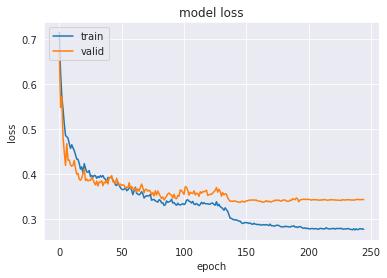

In [20]:
if nas:
    for trial in history: 
        print(trial.summary())
        
    writepath_nas = './results_nas.csv'

    if different_eval_data:
        flat_config = flatten_dict(config_train)
    else:
        flat_config = flatten_dict(config)    

    if not os.path.exists(writepath_nas):
        with open(writepath_nas, 'w+') as text_file:       
            for key in flat_config.keys():
                text_file.write(key)
                text_file.write(';')         

            for hp in history[0].hyperparameters.values.keys():
                text_file.write(hp + ';')    
               
            text_file.write('score')
            
            text_file.write('\n')

    with open(writepath_nas, 'a+') as text_file:  
        for value in flat_config.values():
            text_file.write(str(value))
            text_file.write(';')

        for hp, value in history[0].hyperparameters.values.items():
            text_file.write(str(value) + ';')        

        
        text_file.write(str(history[0].score))
            
        text_file.write('\n')            

        text_file.close()      
        
else:
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')    

In [21]:
if False:
    index = 0
    lambda_net = lambda_net_dataset_train.lambda_net_list[index]
    
    lambda_net_model = network_parameters_to_network(lambda_net.network_parameters, config)
    lambda_net_model_preds = lambda_net_model.predict(lambda_net.X_train_lambda)
    dt_train_data = DecisionTreeClassifier(max_depth=3)
    dt_train_data.fit(lambda_net.X_train_lambda, np.round(lambda_net_model_preds))
    
    random_data = np.random.uniform(0, 1, lambda_net.X_train_lambda.shape)
    lambda_net_model_preds_random = lambda_net_model.predict(random_data)
    dt_random_data = DecisionTreeClassifier(max_depth=3)
    dt_random_data.fit(random_data, np.round(lambda_net_model_preds_random))
    
    plot_decision_area_evaluation(lambda_net.X_train_lambda, 
                                lambda_net.y_train_lambda.flatten(), 
                                lambda_net.X_test_lambda, 
                                lambda_net.y_test_lambda.flatten(),
                                random_data,
                                lambda_net_model_preds_random.flatten(),                                   
                                lambda_net_model,
                                dt_train_data,
                                dt_random_data,
                                dt_random_data,
                                dt_random_data,
                                model.predict(np.array([lambda_net.network_parameters]))[0],
                                np.array([str(i) for i in range(lambda_net.X_train_lambda.shape[1])]),
                                config
                               )

    index = 0
    lambda_net = lambda_net_dataset_valid.lambda_net_list[index]
    
    lambda_net_model = network_parameters_to_network(lambda_net.network_parameters, config)
    lambda_net_model_preds = lambda_net_model.predict(lambda_net.X_train_lambda)
    dt_train_data = DecisionTreeClassifier(max_depth=3)
    dt_train_data.fit(lambda_net.X_train_lambda, np.round(lambda_net_model_preds))
    
    random_data = np.random.uniform(0, 1, lambda_net.X_train_lambda.shape)
    lambda_net_model_preds_random = lambda_net_model.predict(random_data)
    dt_random_data = DecisionTreeClassifier(max_depth=3)
    dt_random_data.fit(random_data, np.round(lambda_net_model_preds_random))
    
    plot_decision_area_evaluation(lambda_net.X_train_lambda, 
                                lambda_net.y_train_lambda.flatten(), 
                                lambda_net.X_test_lambda, 
                                lambda_net.y_test_lambda.flatten(),
                                random_data,
                                lambda_net_model_preds_random.flatten(), 
                                lambda_net_model,
                                dt_train_data,
                                dt_random_data,
                                dt_random_data,
                                dt_random_data,
                                model.predict(np.array([lambda_net.network_parameters]))[0],
                                np.array([str(i) for i in range(lambda_net.X_train_lambda.shape[1])]),
                                config
                               )    

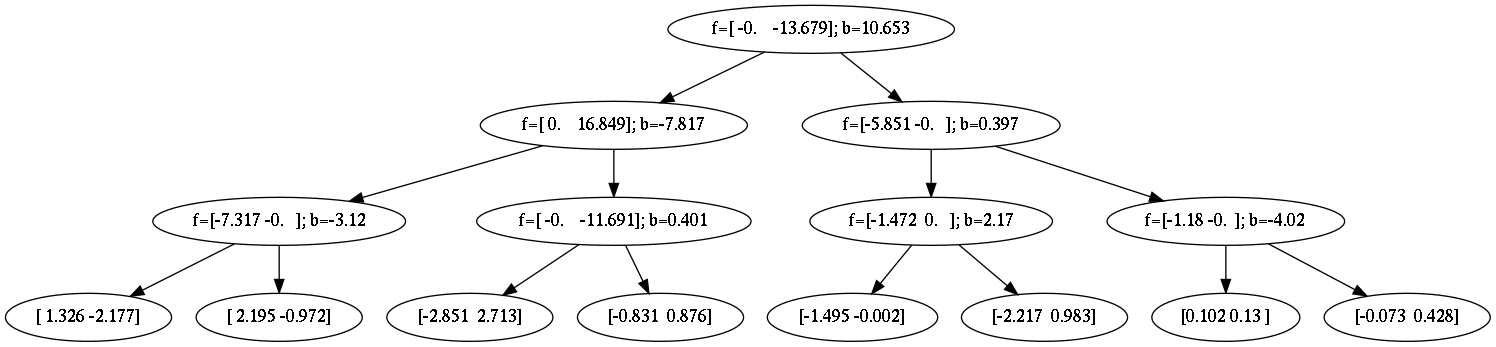

In [22]:
index = 0
if test_size > 0 and not evaluate_distribution:
    network_parameters = np.array([lambda_net_dataset_test.network_parameters_array[index]])
else:
    network_parameters = np.array([lambda_net_dataset_valid.network_parameters_array[index]])
    
if config['i_net']['data_reshape_version'] == 1 or config['i_net']['data_reshape_version'] == 2:
    network_parameters, network_parameters_flat = restructure_data_cnn_lstm(network_parameters, config, subsequences=None)
elif config['i_net']['data_reshape_version'] == 3: #autoencoder
    encoder_model = load_encoder_model(config)
    network_parameters, network_parameters_flat, _ = autoencode_data(network_parameters, config, encoder_model)    
dt_parameters = model.predict(network_parameters)[0]

if config['function_family']['dt_type'] == 'vanilla':
    image, nodes = anytree_decision_tree_from_parameters(dt_parameters, config=config)
else:
    tree = generate_random_decision_tree(config)
    tree.initialize_from_parameter_array(dt_parameters, reshape=True, config=config)
    image = tree.plot_tree()
image

In [23]:
image = None
if not function_value_loss:
    if test_size > 0 and not evaluate_distribution:
        dt_parameters = y_test[index][:-2 ** config['function_family']['maximum_depth'] ]
    else:
        dt_parameters = y_valid[index][:-2 ** config['function_family']['maximum_depth'] ]

    image, nodes = anytree_decision_tree_from_parameters(dt_parameters, config=config)
image

In [24]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 513)]        0           []                               
                                                                                                  
 hidden1_4096 (Dense)           (None, 4096)         2105344     ['input[0][0]']                  
                                                                                                  
 activation1_swish (Activation)  (None, 4096)        0           ['hidden1_4096[0][0]']           
                                                                                                  
 hidden2_2048 (Dense)           (None, 2048)         8390656     ['activation1_swish[0][0]']      
                                                                                              

    Normal: This is useful for looking at means and other linear combinations (e.g. regression coefficients) because of the CLT. Related to that is if something is known to arise due to additive effects of many different small causes then the normal may be a reasonable distribution: for example, many biological measures are the result of multiple genes and multiple environmental factors and therefor are often approximately normal.

    Gamma: Right skewed and useful for things with a natural minimum at 0. Commonly used for elapsed times and some financial variables.

    Exponential: special case of the Gamma. It is memoryless and scales easily.

    Chi-squared (𝜒2): special case of the Gamma. Arises as sum of squared normal variables (so used for variances).

    Beta: Defined between 0 and 1 (but could be transformed to be between other values), useful for proportions or other quantities that must be between 0 and 1.

    Binomial: How many "successes" out of a given number of independent trials with same probability of "success".

    Poisson: Common for counts. Nice properties that if the number of events in a period of time or area follows a Poisson, then the number in twice the time or area still follows the Poisson (with twice the mean): this works for adding Poissons or scaling with values other than 2.

    Note that if events occur over time and the time between occurrences follows an exponential then the number that occur in a time period follows a Poisson.

    Negative Binomial: Counts with minimum 0 (or other value depending on which version) and no upper bound. Conceptually it is the number of "failures" before k "successes". The negative binomial is also a mixture of Poisson variables whose means come from a gamma distribution.

    Geometric: special case for negative binomial where it is the number of "failures" before the 1st "success". If you truncate (round down) an exponential variable to make it discrete, the result is geometric.

## Train & Valid Data Evaluation

In [25]:

mean_train_parameters = np.round(np.mean(lambda_net_dataset_train.network_parameters_array, axis=0), 5)
std_train_parameters = np.round(np.std(lambda_net_dataset_train.network_parameters_array, axis=0), 5)

(inet_evaluation_result_dict_train, 
 inet_evaluation_result_dict_mean_train, 
 dt_distilled_list_train,
 distances_dict) = evaluate_interpretation_net_synthetic_data(lambda_net_dataset_train.network_parameters_array, 
                                                               lambda_net_dataset_train.X_test_lambda_array,
                                                               model,
                                                               config,
                                                               identifier='train',
                                                               mean_train_parameters=mean_train_parameters,
                                                               std_train_parameters=std_train_parameters,
                                                               network_parameters_train_array=lambda_net_dataset_train.network_parameters_array)


(inet_evaluation_result_dict_valid, 
 inet_evaluation_result_dict_mean_valid, 
 dt_distilled_list_valid,
 distances_dict) = evaluate_interpretation_net_synthetic_data(lambda_net_dataset_valid.network_parameters_array, 
                                                               lambda_net_dataset_valid.X_test_lambda_array,
                                                               model,
                                                               config,
                                                               identifier='valid',
                                                               mean_train_parameters=mean_train_parameters,
                                                               std_train_parameters=std_train_parameters,
                                                               network_parameters_train_array=lambda_net_dataset_train.network_parameters_array,
                                                               distances_dict=distances_dict)

[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done  42 out of  50 | elapsed:  1.1min remaining:   12.1s
[Parallel(n_jobs=30)]: Done  50 out of  50 | elapsed:  1.2min finished


  0%|          | 0/50 [00:00<?, ?it/s]

[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done  42 out of  50 | elapsed:   41.2s remaining:    7.8s
[Parallel(n_jobs=30)]: Done  50 out of  50 | elapsed:   56.6s finished


  0%|          | 0/50 [00:00<?, ?it/s]

## Test Data Evaluation (+ Distribution Evaluation)

In [26]:
%load_ext autoreload
%autoreload 2
#set_loky_pickler('pickle')

In [27]:
#config['computation']['n_jobs'] = 60
#config['i_net']['test_size'] = 1000

In [28]:
if evaluate_distribution and test_size > 0:
    
    (distances_dict, 
     inet_evaluation_result_dict_test, 
     inet_evaluation_result_dict_complete_by_distribution_test,
     inet_evaluation_result_dict_mean_test,
     inet_evaluation_result_dict_mean_by_distribution_test,
     inet_evaluation_results_test, 
     dt_inet_list_test, 
     dt_distilled_list_test, 
     data_dict_list_test, 
     normalizer_list_list_test,
     test_network_list_distrib,
     model_history_list,
     distribution_parameter_list_list) = distribution_evaluation_interpretation_net_synthetic_data(loss_function, 
                                                                                            metrics,
                                                                                            #model,
                                                                                           config,
                                                                                           distribution_list_evaluation = config['data']['distribution_list_eval'],#['uniform', 'normal', 'gamma', 'exponential', 'beta', 'binomial', 'poisson'],
                                                                                           identifier='test',
                                                                                           lambda_net_parameters_train=lambda_net_dataset_train.network_parameters_array,
                                                                                           mean_train_parameters=mean_train_parameters,
                                                                                           std_train_parameters=std_train_parameters,
                                                                                           distances_dict=distances_dict,
                                                                                           max_distributions_per_class=max_distributions_per_class,#max_distributions_per_class,
                                                                                           flip_percentage=noise_injected_level, #0.1,#
                                                                                           data_noise=data_noise, #0.1,#
                                                                                           random_parameters = random_parameters_distribution, #random_parameters_distribution
                                                                                           verbose=0,
                                                                                           backend='loky',#sequential
                                                                                    )
else:
    (inet_evaluation_result_dict_test, 
     inet_evaluation_result_dict_mean_test, 
     dt_distilled_list_test,
     distances_dict) = evaluate_interpretation_net_synthetic_data(lambda_net_dataset_test.network_parameters_array, 
                                                                   lambda_net_dataset_test.X_test_lambda_array,
                                                                   model,
                                                                   config,
                                                                   identifier='test',
                                                                   mean_train_parameters=mean_train_parameters,
                                                                   std_train_parameters=std_train_parameters,
                                                                   network_parameters_train_array=lambda_net_dataset_train.network_parameters_array,
                                                                   distances_dict=distances_dict)
    
    print_results_synthetic_evaluation(inet_evaluation_result_dict_mean_train, 
                                       inet_evaluation_result_dict_mean_valid, 
                                       inet_evaluation_result_dict_mean_test, 
                                       distances_dict)    

[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done  68 tasks      | elapsed:  5.2min
[Parallel(n_jobs=30)]: Done 228 tasks      | elapsed: 14.6min
[Parallel(n_jobs=30)]: Done 500 out of 500 | elapsed: 31.2min finished


In [29]:
if evaluate_distribution and test_size > 0:
    #print(distribution_parameter_list_list[0])
    #print(lambda_net_dataset_valid.distribution_dict_list_list[0])

    inet_performance_distrib_evaluation = np.array(inet_evaluation_result_dict_complete_by_distribution_test[list(inet_evaluation_result_dict_complete_by_distribution_test.keys())[0]]['inet_scores']['accuracy'])
    print('I-Net Performance by Network: ', inet_performance_distrib_evaluation)

    mean_random_performance_distrib_evaluation = np.mean(np.array([inet_evaluation_result_dict_complete_by_distribution_test[str(distrib)]['dt_scores']['accuracy'] for distrib in config['data']['distribution_list_eval']]), axis=0)
    print('Distilled Mean Performance by Network: ', mean_random_performance_distrib_evaluation)

    max_random_performance_distrib_evaluation = np.max(np.array([inet_evaluation_result_dict_complete_by_distribution_test[str(distrib)]['dt_scores']['accuracy'] for distrib in config['data']['distribution_list_eval']]), axis=0)
    print('Distilled Max Performance by Network: ', max_random_performance_distrib_evaluation)

    print('Median I-Net:', np.median(inet_evaluation_result_dict_complete_by_distribution_test[list(inet_evaluation_result_dict_complete_by_distribution_test.keys())[0]]['inet_scores']['accuracy']))
    print('Median DT Distilled:', np.median(np.median(np.array([inet_evaluation_result_dict_complete_by_distribution_test[str(distrib)]['dt_scores']['accuracy'] for distrib in config['data']['distribution_list_eval']]), axis=0)))#np.median(inet_evaluation_result_dict_complete_by_distribution_test['uniform']['dt_scores']['accuracy']))

    complete_distribution_evaluation_results = get_complete_distribution_evaluation_results_dataframe(inet_evaluation_result_dict_mean_by_distribution_test)
    display(complete_distribution_evaluation_results.head(20))
    
    network_distances = get_print_network_distances_dataframe(distances_dict)
    display(network_distances.head(20))

I-Net Performance by Network:  [0.74  0.796 1.    ... 0.978 0.904 0.3  ]
Distilled Mean Performance by Network:  [0.732 0.26  0.54  ... 0.966 0.544 0.942]
Distilled Max Performance by Network:  [0.732 0.26  0.54  ... 0.966 0.544 0.942]
Median I-Net: 0.91
Median DT Distilled: 0.57


Acc Distilled Train Data  \
['uniform', 'normal', 'gamma', 'beta', 'poisson']                     0.721   

                                                   Acc Distilled Data Random  \
['uniform', 'normal', 'gamma', 'beta', 'poisson']                      0.904   

                                                   Acc Distilled  Acc I-Net  \
['uniform', 'normal', 'gamma', 'beta', 'poisson']          0.589      0.874   

                                                   Soft BC Distilled Train Data  \
['uniform', 'normal', 'gamma', 'beta', 'poisson']                         0.669   

                                                   Soft BC Distilled Data Random  \
['uniform', 'normal', 'gamma', 'beta', 'poisson']                          0.536   

                                                   Soft BC Distilled  \
['uniform', 'normal', 'gamma', 'beta', 'poisson']              0.716   

                                                   Soft BC I-Net  \
['uniform', 'normal', 'gamma', 'beta', 'poisson']          0.610   

                                                   BC Distilled Train Data  \
['uniform', 'normal', 'gamma', 'beta', 'poisson']                    0.526   

                                                   BC Distilled Data Random  \
['uniform', 'normal', 'gamma', 'beta', 'poisson']                     0.271   

                                                   BC Distilled  BC I-Net  \
['uniform', 'normal', 'gamma', 'beta', 'poisson']         1.011     0.311   

                                                   F1 Score Distilled Train Data  \
['uniform', 'normal', 'gamma', 'beta', 'poisson']                          0.653   

                                                   F1 Score Distilled Data Random  \
['uniform', 'normal', 'gamma', 'beta', 'poisson']                           0.881   

                                                   F1 Score Distilled  \
['uniform', 'normal', 'gamma', 'beta', 'poisson']               0.488   

                                                   F1 Score I-Net  \
['uniform', 'normal', 'gamma', 'beta', 'poisson']           0.861   

                                                   ROC AUC Score Distilled Train Data  \
['uniform', 'normal', 'gamma', 'beta', 'poisson']                               0.709   

                                                   ROC AUC Score Distilled Data Random  \
['uniform', 'normal', 'gamma', 'beta', 'poisson']                                0.655   

                                                   ROC AUC Score Distilled  \
['uniform', 'normal', 'gamma', 'beta', 'poisson']                    0.580   

                                                   ROC AUC Score I-Net  \
['uniform', 'normal', 'gamma', 'beta', 'poisson']                0.914   

                                                   Runtime Distilled Train Data  \
['uniform', 'normal', 'gamma', 'beta', 'poisson']                        23.483   

                                                   Runtime Distilled Data Random  \
['uniform', 'normal', 'gamma', 'beta', 'poisson']                         23.483   

                                                   Runtime Distilled  \
['uniform', 'normal', 'gamma', 'beta', 'poisson']             23.483   

                                                   Runtime I-Net  
['uniform', 'normal', 'gamma', 'beta', 'poisson']          0.234

Average Z-Score (Sample to Train Data)  \
train                                 217.278   
valid                                 231.446   
test                                  227.302   

       Average Distance to Initialization  \
train                              92.099   
valid                             101.146   
test                              101.025   

       Average Mean Distance to Train Data  \
train                              143.633   
valid                              149.109   
test                               151.430   

       Average Distance to closest Train Data Sample  \
train                                          0.000   
valid                                         49.145   
test                                          34.029   

       Average Biggest Distance for Single Neuron  \
train                                       4.123   
valid                                       4.417   
test                                        4.456   

       Minimum Biggest Distance for Single Neuron  
train                                       0.000  
valid                                       1.532  
test                                        1.627

In [30]:
#%load_ext autoreload
#%autoreload 2

Index:  278
Feature 1:  Samples 4257 / 743
	 Distribution 1: gamma
		 shape: 1.417
		 scale: 0.128
	 Distribution 2: gamma
		 shape: 3.332
		 scale: 2.923
Feature 2:  Samples 4171 / 829
	 Distribution 1: uniform
		 low: 0.608
		 high: 2.005
	 Distribution 2: uniform
		 low: 0.882
		 high: 4.566
Considered Columns:								 0   1
Performance Network:								 0.654
Fidelity DT Sklearn Train Data:							 0.864
Fidelity DT Distilled (['uniform', 'normal', 'gamma', 'beta', 'poisson']):   	 0.136
Fidelity DT Sklearn Uniform Data:						 0.136
Fidelity DT Sklearn Normal Data:						 0.136
Fidelity DT I-Net:								 0.996


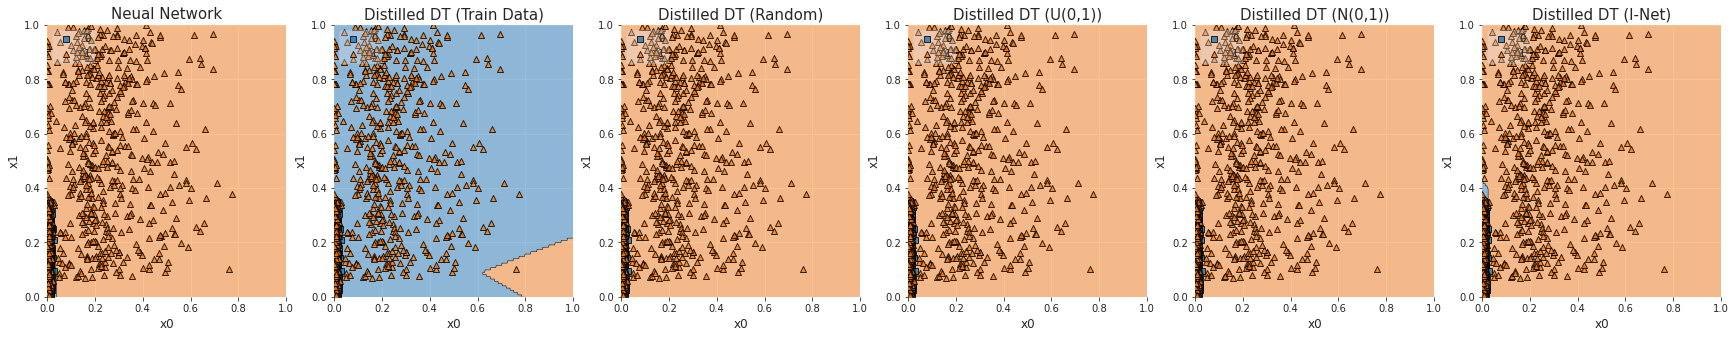

-----------------------------------------------------
Index:  59
Feature 1:  Samples 4274 / 726
	 Distribution 1: poisson
		 lam: 3.462
	 Distribution 2: poisson
		 lam: 3.968
Feature 2:  Samples 3933 / 1067
	 Distribution 1: uniform
		 low: 2.565
		 high: 3.39
	 Distribution 2: uniform
		 low: 0.468
		 high: 1.915
Considered Columns:								 0   1
Performance Network:								 0.708
Fidelity DT Sklearn Train Data:							 0.874
Fidelity DT Distilled (['uniform', 'normal', 'gamma', 'beta', 'poisson']):   	 0.182
Fidelity DT Sklearn Uniform Data:						 0.182
Fidelity DT Sklearn Normal Data:						 0.182
Fidelity DT I-Net:								 1.0


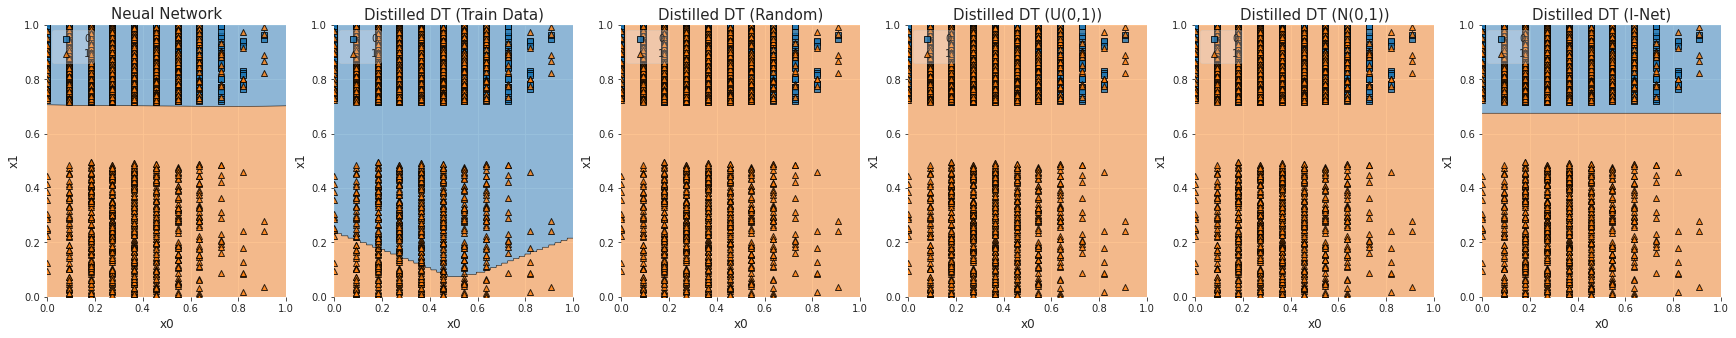

-----------------------------------------------------
Index:  472
Feature 1:  Samples 4371 / 629
	 Distribution 1: beta
		 a: 0.032
		 b: 4.69
	 Distribution 2: beta
		 a: 2.523
		 b: 0.514
Feature 2:  Samples 4636 / 364
	 Distribution 1: uniform
		 low: 1.235
		 high: 4.057
	 Distribution 2: uniform
		 low: 0.608
		 high: 4.385
Considered Columns:								 0   1
Performance Network:								 0.65
Fidelity DT Sklearn Train Data:							 0.87
Fidelity DT Distilled (['uniform', 'normal', 'gamma', 'beta', 'poisson']):   	 0.144
Fidelity DT Sklearn Uniform Data:						 0.144
Fidelity DT Sklearn Normal Data:						 0.144
Fidelity DT I-Net:								 0.95


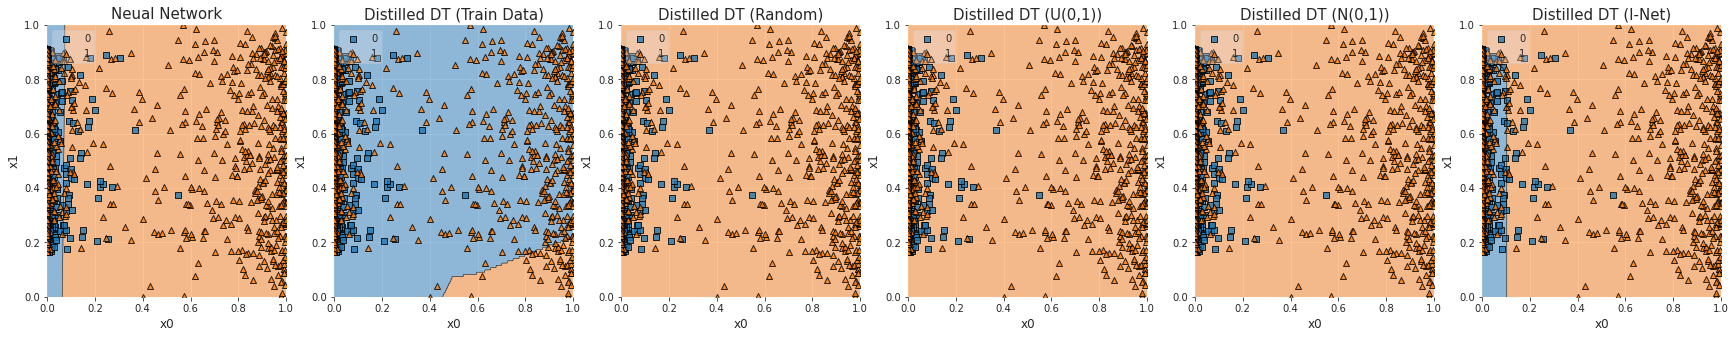

-----------------------------------------------------
Index:  126
Feature 1:  Samples 3943 / 1057
	 Distribution 1: gamma
		 shape: 2.761
		 scale: 0.431
	 Distribution 2: gamma
		 shape: 3.495
		 scale: 0.842
Feature 2:  Samples 3977 / 1023
	 Distribution 1: uniform
		 low: 2.56
		 high: 3.201
	 Distribution 2: uniform
		 low: 0.637
		 high: 4.832
Considered Columns:								 0   1
Performance Network:								 0.678
Fidelity DT Sklearn Train Data:							 0.86
Fidelity DT Distilled (['uniform', 'normal', 'gamma', 'beta', 'poisson']):   	 0.168
Fidelity DT Sklearn Uniform Data:						 0.168
Fidelity DT Sklearn Normal Data:						 0.168
Fidelity DT I-Net:								 0.956


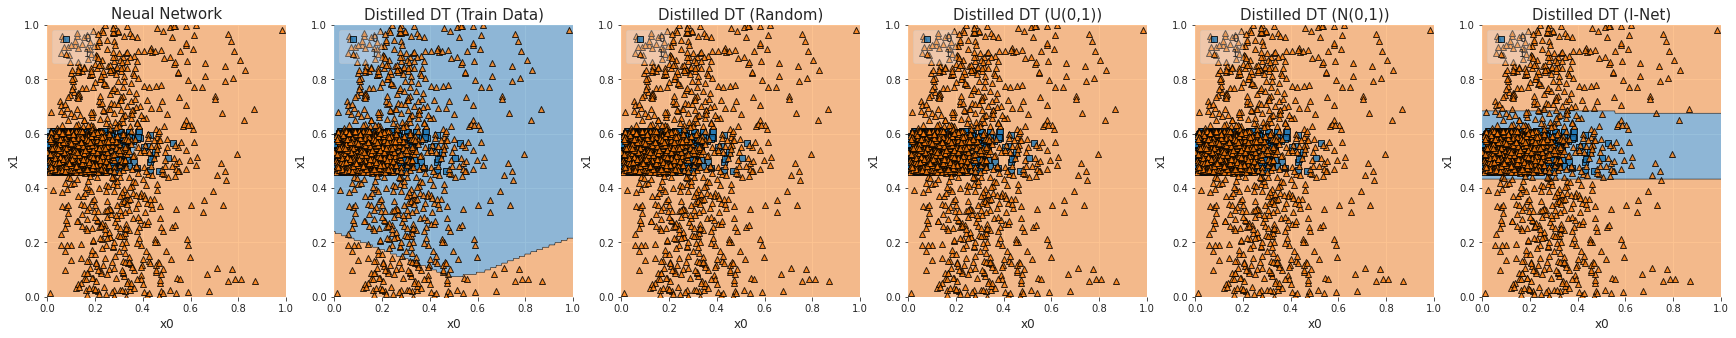

-----------------------------------------------------
Index:  241
Feature 1:  Samples 4525 / 475
	 Distribution 1: gamma
		 shape: 1.684
		 scale: 0.537
	 Distribution 2: gamma
		 shape: 1.747
		 scale: 4.77
Feature 2:  Samples 4918 / 82
	 Distribution 1: uniform
		 low: 2.617
		 high: 3.706
	 Distribution 2: uniform
		 low: 1.64
		 high: 4.514
Considered Columns:								 0   1
Performance Network:								 0.568
Fidelity DT Sklearn Train Data:							 0.874
Fidelity DT Distilled (['uniform', 'normal', 'gamma', 'beta', 'poisson']):   	 0.126
Fidelity DT Sklearn Uniform Data:						 0.126
Fidelity DT Sklearn Normal Data:						 0.126
Fidelity DT I-Net:								 0.874


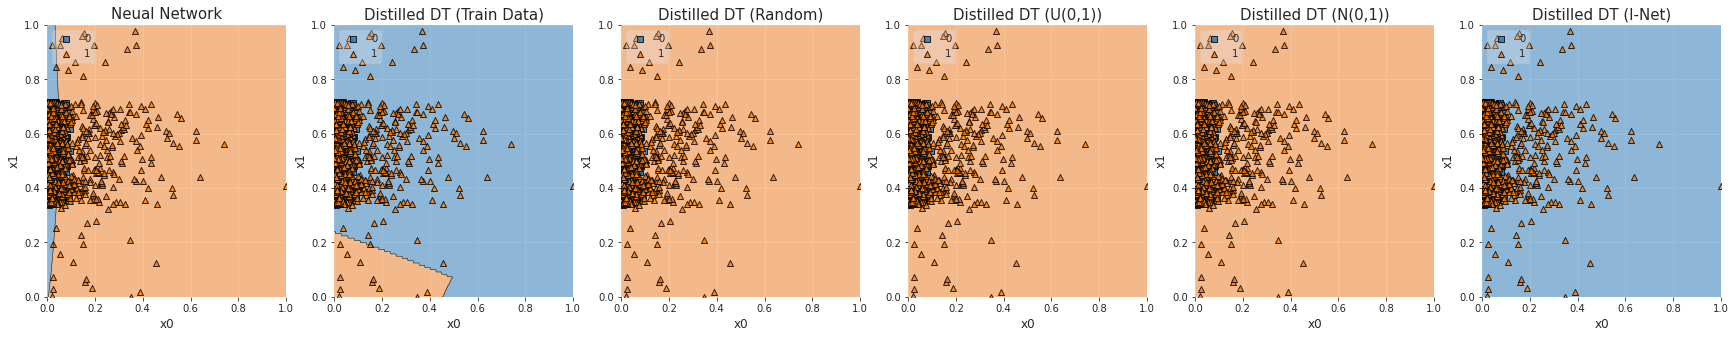

-----------------------------------------------------
Index:  76
Feature 1:  Samples 2722 / 2278
	 Distribution 1: uniform
		 low: 3.211
		 high: 4.596
	 Distribution 2: uniform
		 low: 2.855
		 high: 4.512
Feature 2:  Samples 1078 / 3922
	 Distribution 1: uniform
		 low: 2.539
		 high: 3.153
	 Distribution 2: uniform
		 low: 3.873
		 high: 3.95
Considered Columns:								 0   1
Performance Network:								 0.726
Fidelity DT Sklearn Train Data:							 0.824
Fidelity DT Distilled (['uniform', 'normal', 'gamma', 'beta', 'poisson']):   	 0.26
Fidelity DT Sklearn Uniform Data:						 0.26
Fidelity DT Sklearn Normal Data:						 0.26
Fidelity DT I-Net:								 0.99


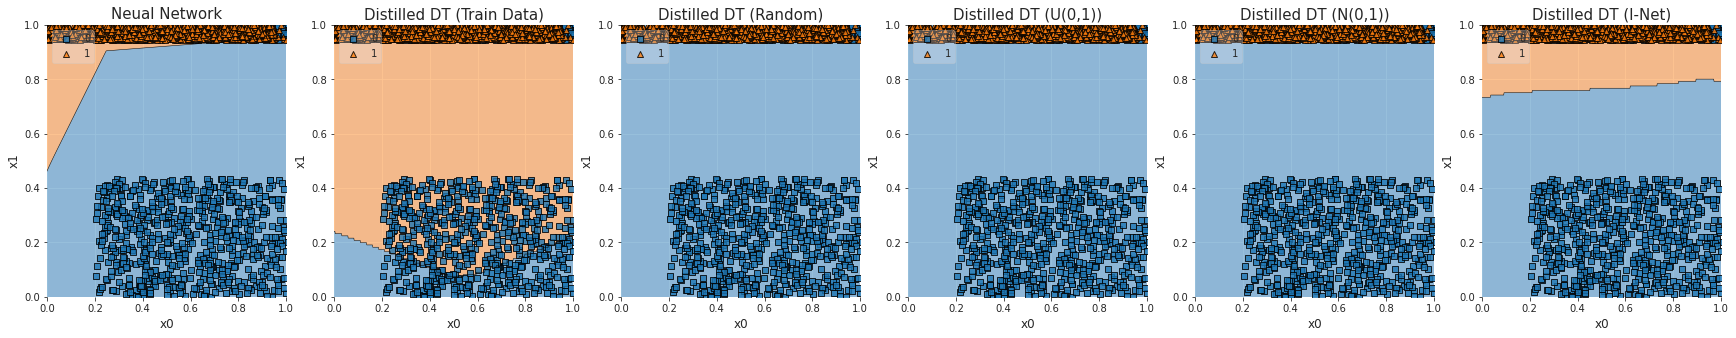

-----------------------------------------------------
Index:  171
Feature 1:  Samples 3518 / 1482
	 Distribution 1: uniform
		 low: 0.623
		 high: 0.747
	 Distribution 2: uniform
		 low: 0.972
		 high: 2.437
Feature 2:  Samples 517 / 4483
	 Distribution 1: uniform
		 low: 1.569
		 high: 3.847
	 Distribution 2: uniform
		 low: 1.682
		 high: 2.582
Considered Columns:								 0   1
Performance Network:								 0.8
Fidelity DT Sklearn Train Data:							 0.752
Fidelity DT Distilled (['uniform', 'normal', 'gamma', 'beta', 'poisson']):   	 0.274
Fidelity DT Sklearn Uniform Data:						 0.274
Fidelity DT Sklearn Normal Data:						 0.274
Fidelity DT I-Net:								 1.0


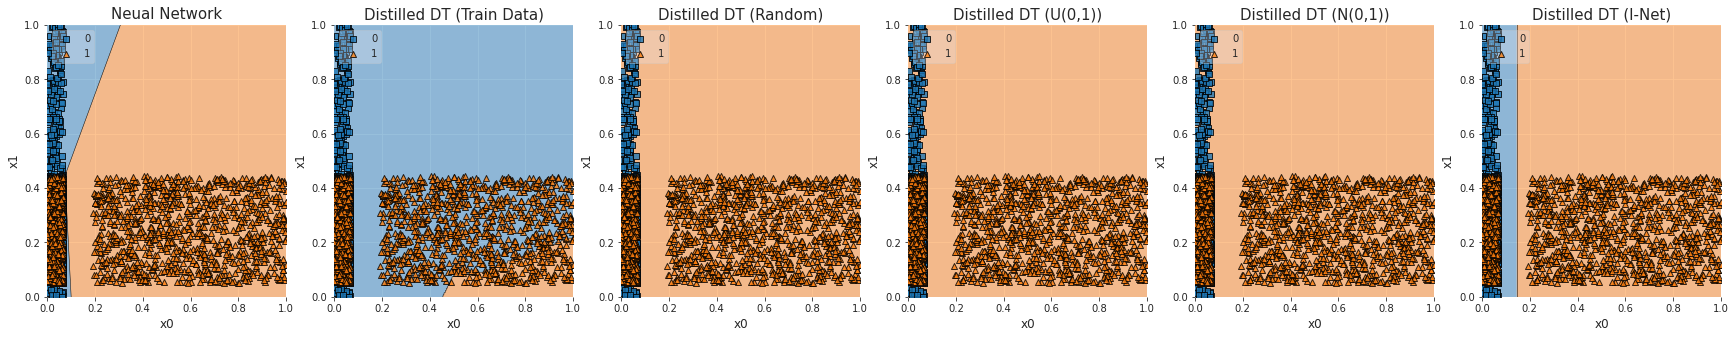

-----------------------------------------------------
Index:  443
Feature 1:  Samples 3569 / 1431
	 Distribution 1: gamma
		 shape: 0.196
		 scale: 0.328
	 Distribution 2: gamma
		 shape: 3.852
		 scale: 1.653
Feature 2:  Samples 3501 / 1499
	 Distribution 1: normal
		 loc: 2.417
		 scale: 4.605
	 Distribution 2: normal
		 loc: 1.689
		 scale: 4.922
Considered Columns:								 0   1
Performance Network:								 0.782
Fidelity DT Sklearn Train Data:							 0.728
Fidelity DT Distilled (['uniform', 'normal', 'gamma', 'beta', 'poisson']):   	 0.272
Fidelity DT Sklearn Uniform Data:						 0.272
Fidelity DT Sklearn Normal Data:						 0.272
Fidelity DT I-Net:								 0.994


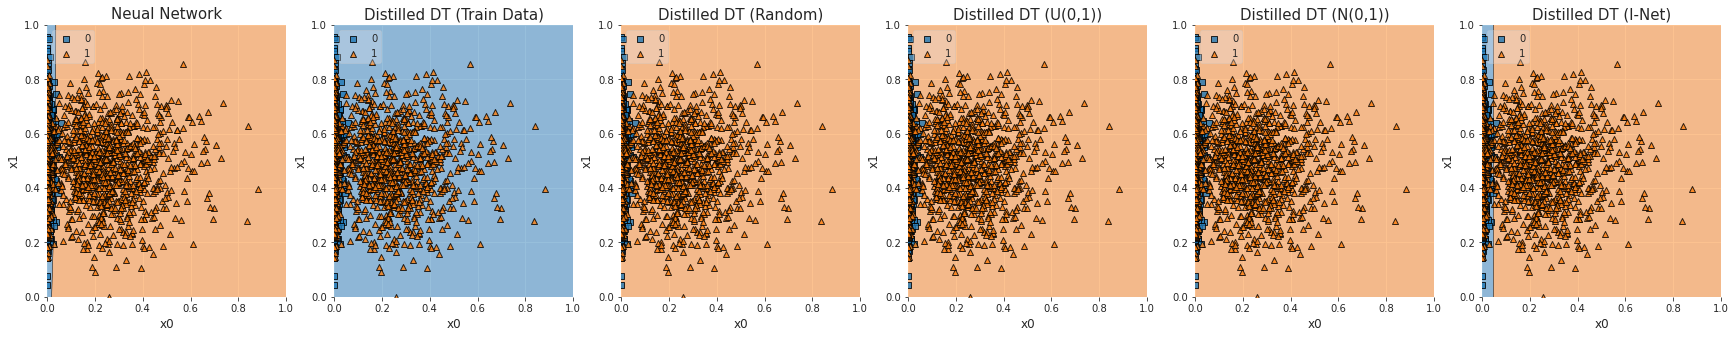

-----------------------------------------------------
Index:  488
Feature 1:  Samples 4232 / 768
	 Distribution 1: normal
		 loc: 0.3
		 scale: 0.447
	 Distribution 2: normal
		 loc: 1.714
		 scale: 3.842
Feature 2:  Samples 4834 / 166
	 Distribution 1: beta
		 a: 4.973
		 b: 1.623
	 Distribution 2: beta
		 a: 3.638
		 b: 2.754
Considered Columns:								 0   1
Performance Network:								 0.616
Fidelity DT Sklearn Train Data:							 0.83
Fidelity DT Distilled (['uniform', 'normal', 'gamma', 'beta', 'poisson']):   	 0.17
Fidelity DT Sklearn Uniform Data:						 0.17
Fidelity DT Sklearn Normal Data:						 0.17
Fidelity DT I-Net:								 0.888


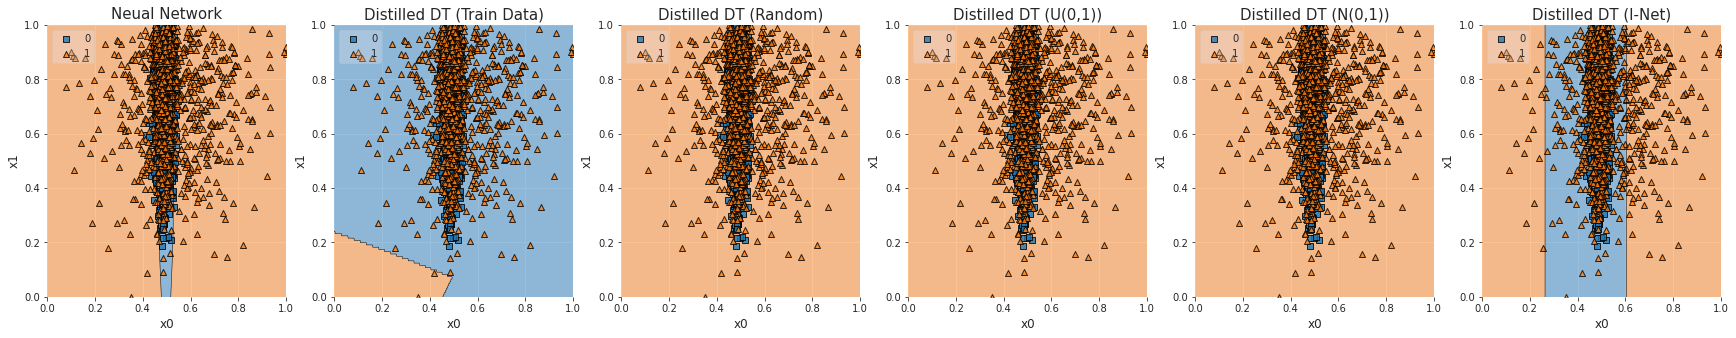

-----------------------------------------------------
Index:  385
Feature 1:  Samples 3822 / 1178
	 Distribution 1: normal
		 loc: 4.156
		 scale: 0.503
	 Distribution 2: normal
		 loc: 1.032
		 scale: 4.289
Feature 2:  Samples 4452 / 548
	 Distribution 1: beta
		 a: 0.723
		 b: 0.369
	 Distribution 2: beta
		 a: 2.026
		 b: 2.316
Considered Columns:								 0   1
Performance Network:								 0.702
Fidelity DT Sklearn Train Data:							 0.806
Fidelity DT Distilled (['uniform', 'normal', 'gamma', 'beta', 'poisson']):   	 0.208
Fidelity DT Sklearn Uniform Data:						 0.208
Fidelity DT Sklearn Normal Data:						 0.208
Fidelity DT I-Net:								 0.91


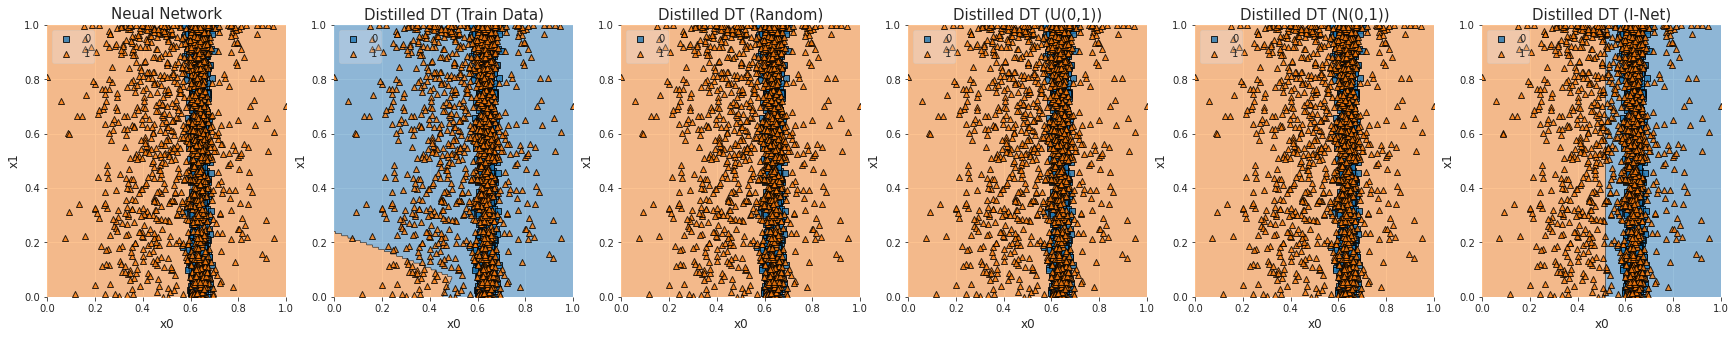

-----------------------------------------------------
Index:  425
Feature 1:  Samples 1166 / 3834
	 Distribution 1: gamma
		 shape: 3.384
		 scale: 3.455
	 Distribution 2: gamma
		 shape: 4.568
		 scale: 0.331
Feature 2:  Samples 1023 / 3977
	 Distribution 1: gamma
		 shape: 3.935
		 scale: 4.888
	 Distribution 2: gamma
		 shape: 0.38
		 scale: 4.172
Considered Columns:								 0   1
Performance Network:								 0.732
Fidelity DT Sklearn Train Data:							 0.918
Fidelity DT Distilled (['uniform', 'normal', 'gamma', 'beta', 'poisson']):   	 0.27
Fidelity DT Sklearn Uniform Data:						 0.27
Fidelity DT Sklearn Normal Data:						 0.27
Fidelity DT I-Net:								 0.972


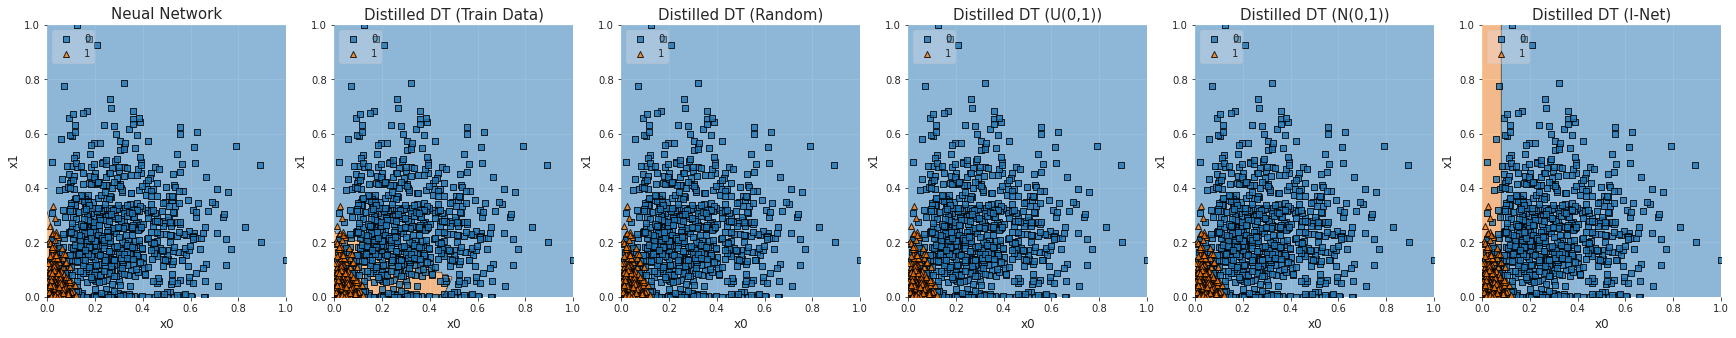

-----------------------------------------------------
Index:  338
Feature 1:  Samples 1616 / 3384
	 Distribution 1: uniform
		 low: 0.858
		 high: 3.189
	 Distribution 2: uniform
		 low: 0.609
		 high: 1.309
Feature 2:  Samples 120 / 4880
	 Distribution 1: normal
		 loc: 3.502
		 scale: 2.657
	 Distribution 2: normal
		 loc: 1.114
		 scale: 3.708
Considered Columns:								 0   1
Performance Network:								 0.752
Fidelity DT Sklearn Train Data:							 0.724
Fidelity DT Distilled (['uniform', 'normal', 'gamma', 'beta', 'poisson']):   	 0.286
Fidelity DT Sklearn Uniform Data:						 0.308
Fidelity DT Sklearn Normal Data:						 0.286
Fidelity DT I-Net:								 0.992


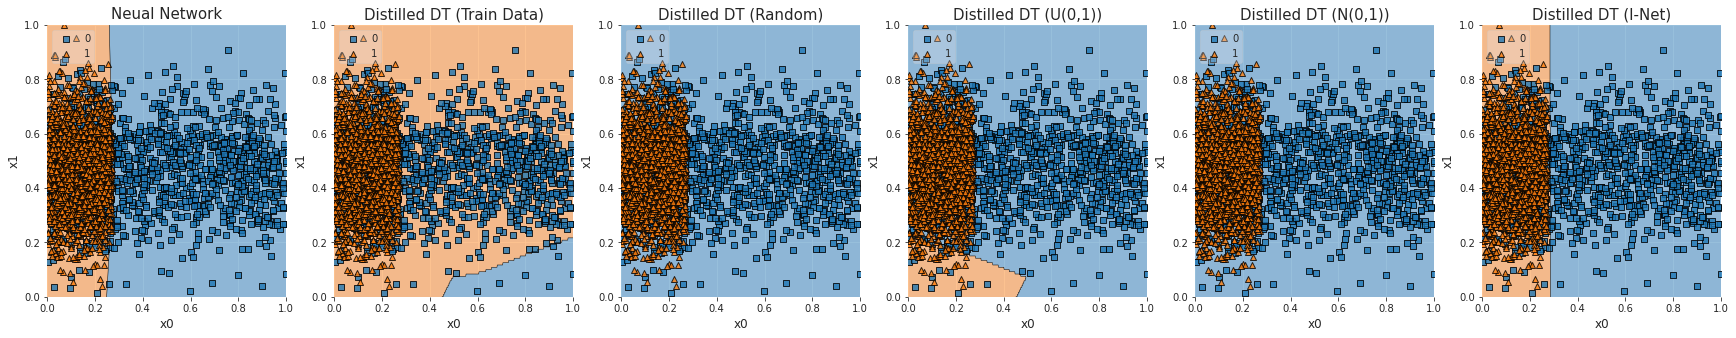

-----------------------------------------------------
Index:  310
Feature 1:  Samples 3709 / 1291
	 Distribution 1: poisson
		 lam: 2.714
	 Distribution 2: poisson
		 lam: 2.581
Feature 2:  Samples 2990 / 2010
	 Distribution 1: uniform
		 low: 3.303
		 high: 4.357
	 Distribution 2: uniform
		 low: 0.853
		 high: 4.393
Considered Columns:								 0   1
Performance Network:								 0.77
Fidelity DT Sklearn Train Data:							 0.792
Fidelity DT Distilled (['uniform', 'normal', 'gamma', 'beta', 'poisson']):   	 0.26
Fidelity DT Sklearn Uniform Data:						 0.26
Fidelity DT Sklearn Normal Data:						 0.26
Fidelity DT I-Net:								 0.958


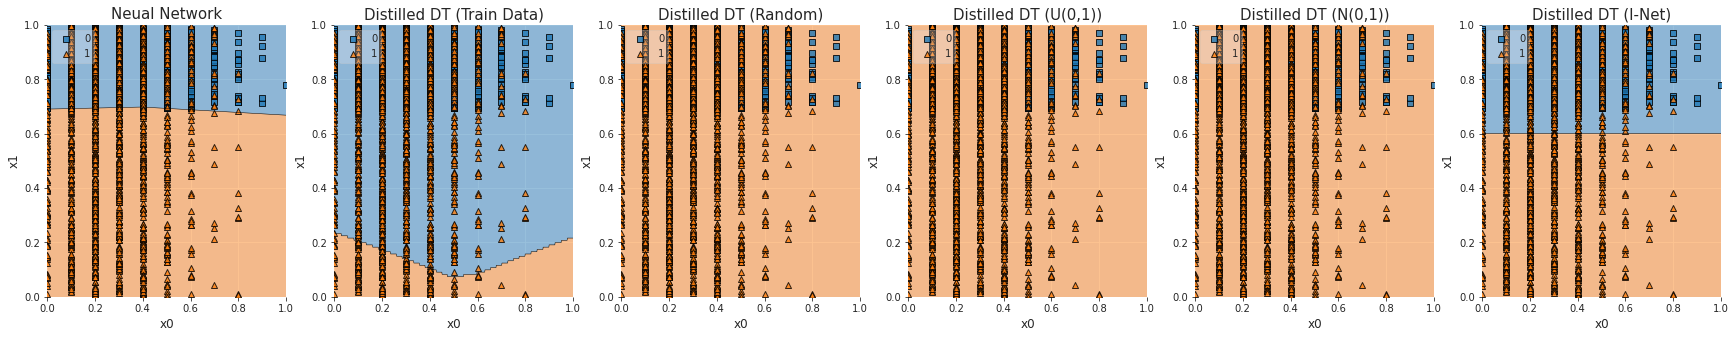

-----------------------------------------------------
Index:  108
Feature 1:  Samples 4196 / 804
	 Distribution 1: normal
		 loc: 3.496
		 scale: 0.973
	 Distribution 2: normal
		 loc: 3.541
		 scale: 4.03
Feature 2:  Samples 4492 / 508
	 Distribution 1: normal
		 loc: 3.274
		 scale: 3.988
	 Distribution 2: normal
		 loc: 3.706
		 scale: 2.551
Considered Columns:								 0   1
Performance Network:								 0.604
Fidelity DT Sklearn Train Data:							 0.834
Fidelity DT Distilled (['uniform', 'normal', 'gamma', 'beta', 'poisson']):   	 0.166
Fidelity DT Sklearn Uniform Data:						 0.166
Fidelity DT Sklearn Normal Data:						 0.166
Fidelity DT I-Net:								 0.864


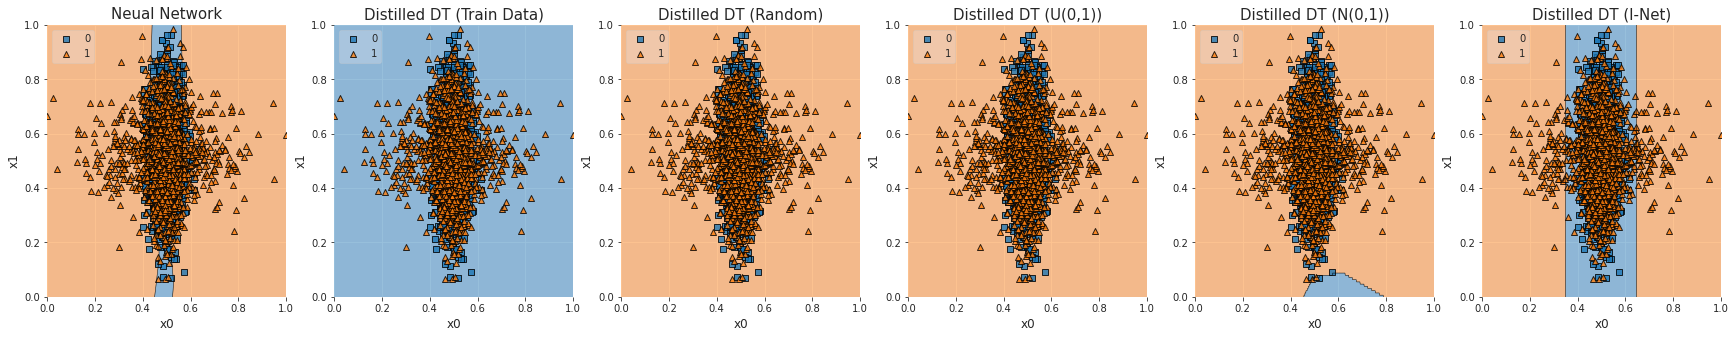

-----------------------------------------------------
Index:  423
Feature 1:  Samples 57 / 4943
	 Distribution 1: beta
		 a: 2.705
		 b: 4.334
	 Distribution 2: beta
		 a: 2.096
		 b: 1.047
Feature 2:  Samples 4281 / 719
	 Distribution 1: uniform
		 low: 1.529
		 high: 2.256
	 Distribution 2: uniform
		 low: 0.076
		 high: 2.947
Considered Columns:								 0   1
Performance Network:								 0.612
Fidelity DT Sklearn Train Data:							 0.824
Fidelity DT Distilled (['uniform', 'normal', 'gamma', 'beta', 'poisson']):   	 0.194
Fidelity DT Sklearn Uniform Data:						 0.194
Fidelity DT Sklearn Normal Data:						 0.194
Fidelity DT I-Net:								 0.884


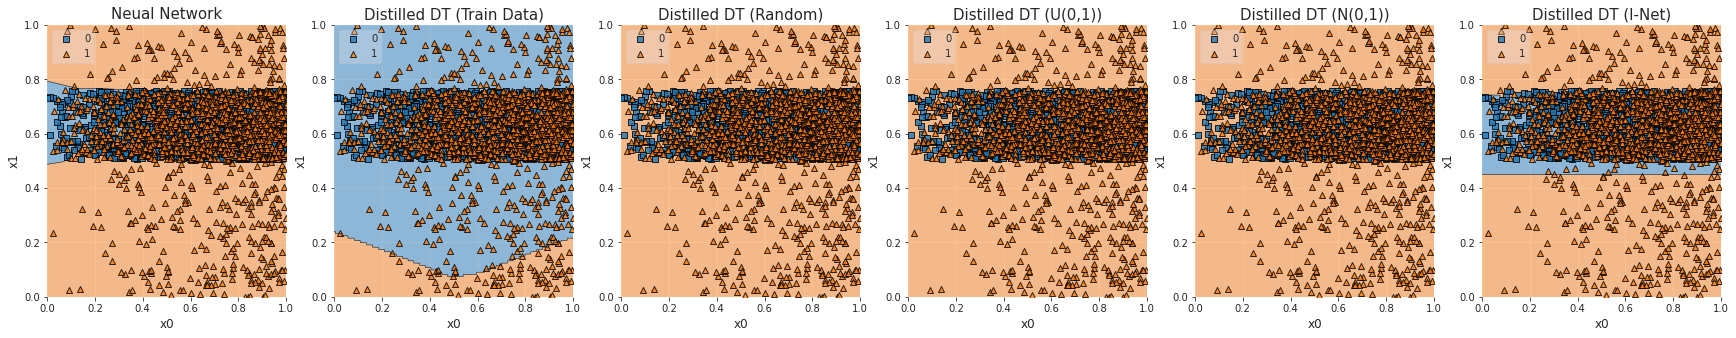

-----------------------------------------------------
Index:  297
Feature 1:  Samples 3249 / 1751
	 Distribution 1: gamma
		 shape: 0.512
		 scale: 1.309
	 Distribution 2: gamma
		 shape: 4.659
		 scale: 4.742
Feature 2:  Samples 4533 / 467
	 Distribution 1: uniform
		 low: 0.754
		 high: 4.309
	 Distribution 2: uniform
		 low: 1.637
		 high: 4.34
Considered Columns:								 0   1
Performance Network:								 0.822
Fidelity DT Sklearn Train Data:							 0.686
Fidelity DT Distilled (['uniform', 'normal', 'gamma', 'beta', 'poisson']):   	 0.32
Fidelity DT Sklearn Uniform Data:						 0.32
Fidelity DT Sklearn Normal Data:						 0.32
Fidelity DT I-Net:								 0.998


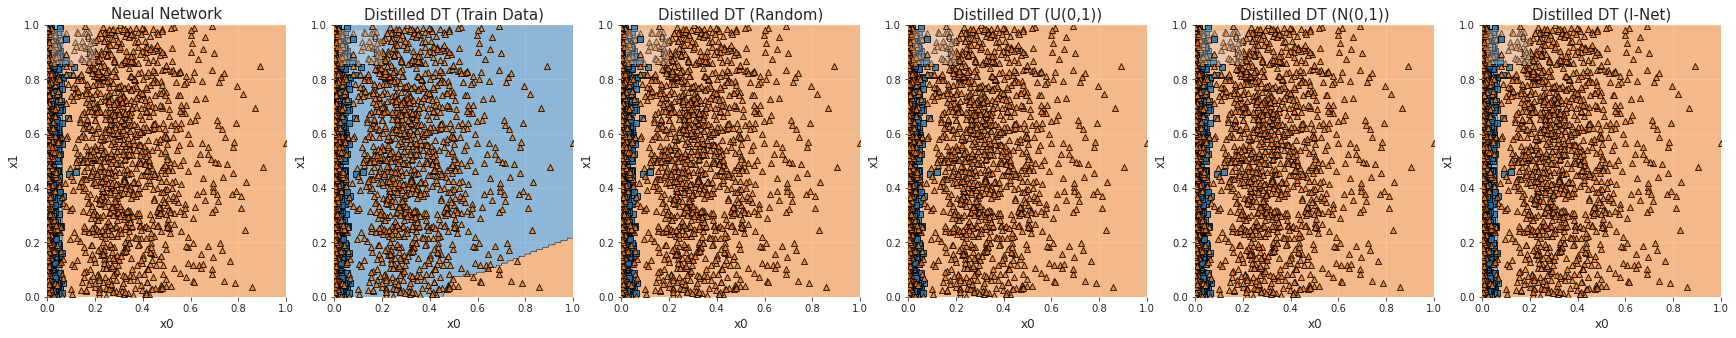

-----------------------------------------------------
Index:  85
Feature 1:  Samples 4459 / 541
	 Distribution 1: uniform
		 low: 1.013
		 high: 1.035
	 Distribution 2: uniform
		 low: 0.162
		 high: 3.767
Feature 2:  Samples 3911 / 1089
	 Distribution 1: beta
		 a: 1.608
		 b: 1.274
	 Distribution 2: beta
		 a: 2.447
		 b: 1.005
Considered Columns:								 0   1
Performance Network:								 0.628
Fidelity DT Sklearn Train Data:							 0.786
Fidelity DT Distilled (['uniform', 'normal', 'gamma', 'beta', 'poisson']):   	 0.214
Fidelity DT Sklearn Uniform Data:						 0.214
Fidelity DT Sklearn Normal Data:						 0.214
Fidelity DT I-Net:								 0.878


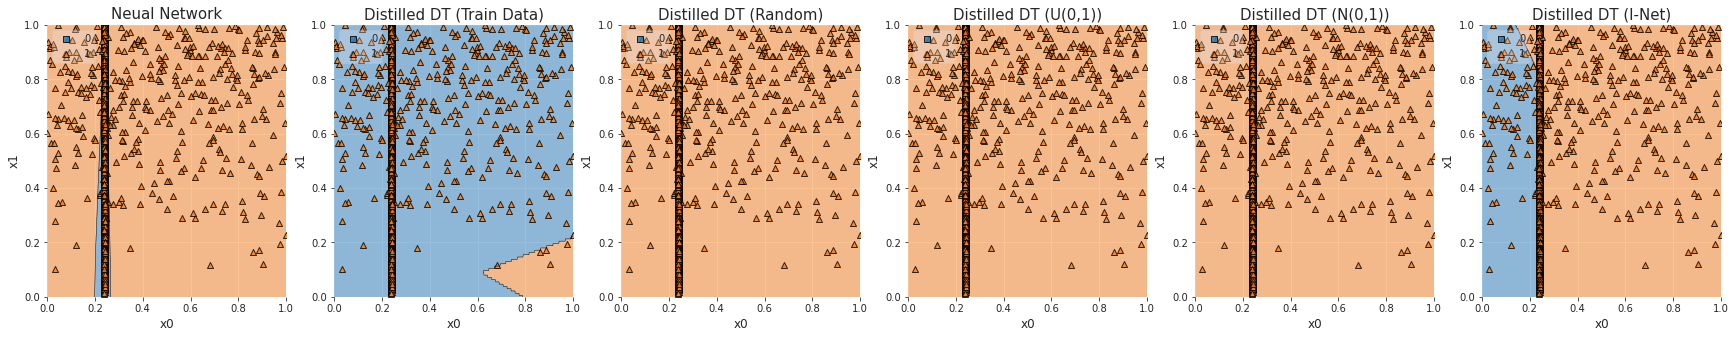

-----------------------------------------------------
Index:  479
Feature 1:  Samples 299 / 4701
	 Distribution 1: beta
		 a: 3.291
		 b: 0.235
	 Distribution 2: beta
		 a: 2.032
		 b: 2.325
Feature 2:  Samples 1089 / 3911
	 Distribution 1: normal
		 loc: 4.374
		 scale: 3.72
	 Distribution 2: normal
		 loc: 0.849
		 scale: 1.868
Considered Columns:								 0   1
Performance Network:								 0.628
Fidelity DT Sklearn Train Data:							 0.72
Fidelity DT Distilled (['uniform', 'normal', 'gamma', 'beta', 'poisson']):   	 0.286
Fidelity DT Sklearn Uniform Data:						 0.286
Fidelity DT Sklearn Normal Data:						 0.284
Fidelity DT I-Net:								 0.938


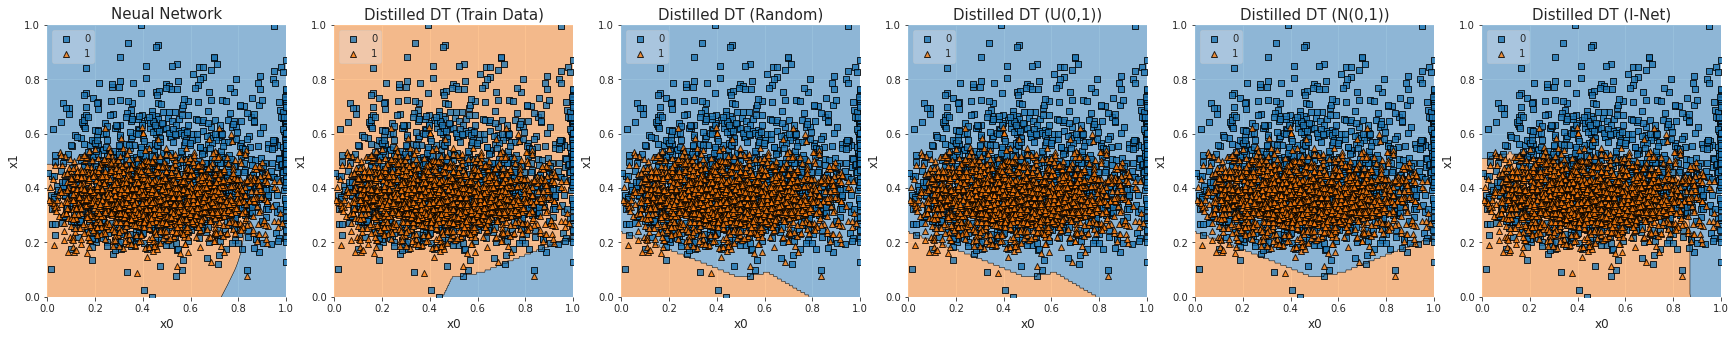

-----------------------------------------------------
Index:  22
Feature 1:  Samples 2934 / 2066
	 Distribution 1: poisson
		 lam: 0.012
	 Distribution 2: poisson
		 lam: 2.06
Feature 2:  Samples 1564 / 3436
	 Distribution 1: normal
		 loc: 1.245
		 scale: 3.79
	 Distribution 2: normal
		 loc: 4.159
		 scale: 2.217
Considered Columns:								 0   1
Performance Network:								 0.854
Fidelity DT Sklearn Train Data:							 0.656
Fidelity DT Distilled (['uniform', 'normal', 'gamma', 'beta', 'poisson']):   	 0.344
Fidelity DT Sklearn Uniform Data:						 0.344
Fidelity DT Sklearn Normal Data:						 0.344
Fidelity DT I-Net:								 0.996


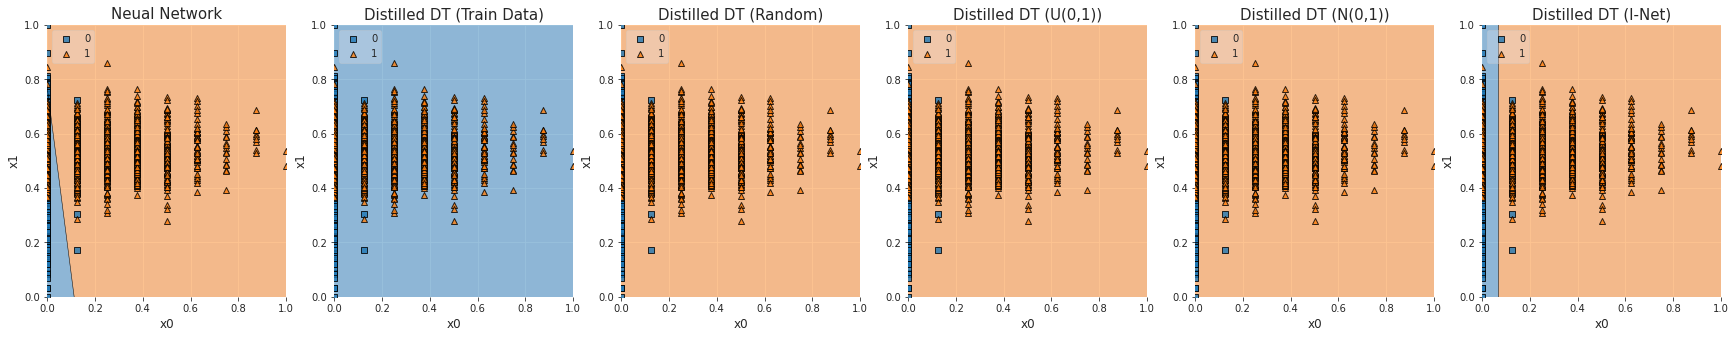

-----------------------------------------------------
Index:  341
Feature 1:  Samples 4900 / 100
	 Distribution 1: gamma
		 shape: 4.671
		 scale: 1.605
	 Distribution 2: gamma
		 shape: 0.03
		 scale: 0.576
Feature 2:  Samples 646 / 4354
	 Distribution 1: normal
		 loc: 1.604
		 scale: 4.251
	 Distribution 2: normal
		 loc: 4.764
		 scale: 0.398
Considered Columns:								 0   1
Performance Network:								 0.602
Fidelity DT Sklearn Train Data:							 0.832
Fidelity DT Distilled (['uniform', 'normal', 'gamma', 'beta', 'poisson']):   	 0.176
Fidelity DT Sklearn Uniform Data:						 0.176
Fidelity DT Sklearn Normal Data:						 0.176
Fidelity DT I-Net:								 0.824


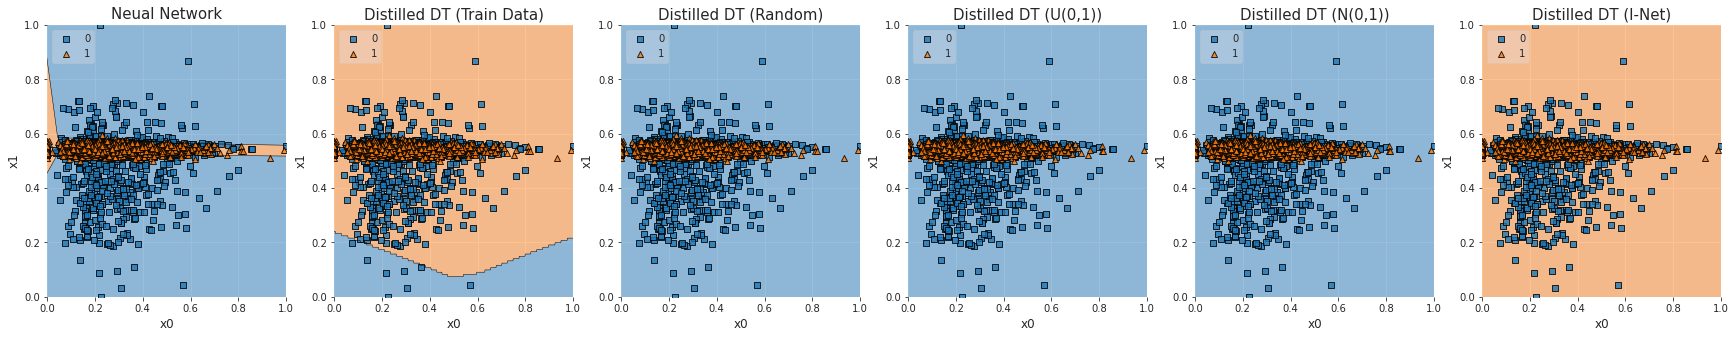

-----------------------------------------------------
Index:  409
Feature 1:  Samples 3948 / 1052
	 Distribution 1: poisson
		 lam: 0.343
	 Distribution 2: poisson
		 lam: 0.784
Feature 2:  Samples 4424 / 576
	 Distribution 1: gamma
		 shape: 2.213
		 scale: 2.999
	 Distribution 2: gamma
		 shape: 1.996
		 scale: 4.63
Considered Columns:								 0   1
Performance Network:								 0.554
Fidelity DT Sklearn Train Data:							 0.666
Fidelity DT Distilled (['uniform', 'normal', 'gamma', 'beta', 'poisson']):   	 0.356
Fidelity DT Sklearn Uniform Data:						 0.356
Fidelity DT Sklearn Normal Data:						 0.356
Fidelity DT I-Net:								 0.998


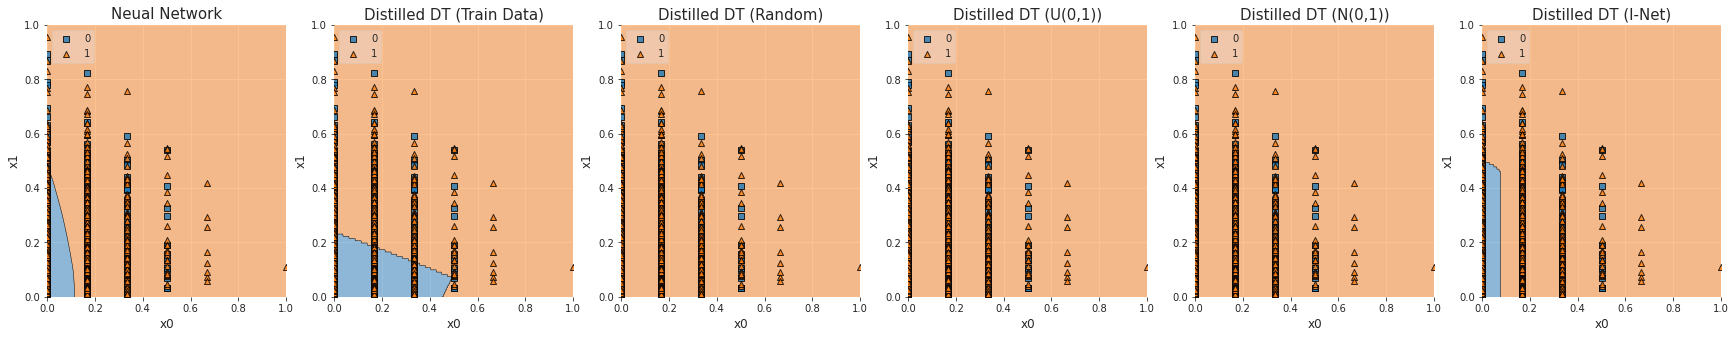

-----------------------------------------------------
Index:  395
Feature 1:  Samples 3445 / 1555
	 Distribution 1: gamma
		 shape: 0.073
		 scale: 2.812
	 Distribution 2: gamma
		 shape: 1.67
		 scale: 1.538
Feature 2:  Samples 3754 / 1246
	 Distribution 1: beta
		 a: 1.331
		 b: 3.334
	 Distribution 2: beta
		 a: 0.379
		 b: 3.116
Considered Columns:								 0   1
Performance Network:								 0.752
Fidelity DT Sklearn Train Data:							 0.658
Fidelity DT Distilled (['uniform', 'normal', 'gamma', 'beta', 'poisson']):   	 0.358
Fidelity DT Sklearn Uniform Data:						 0.358
Fidelity DT Sklearn Normal Data:						 0.358
Fidelity DT I-Net:								 0.976


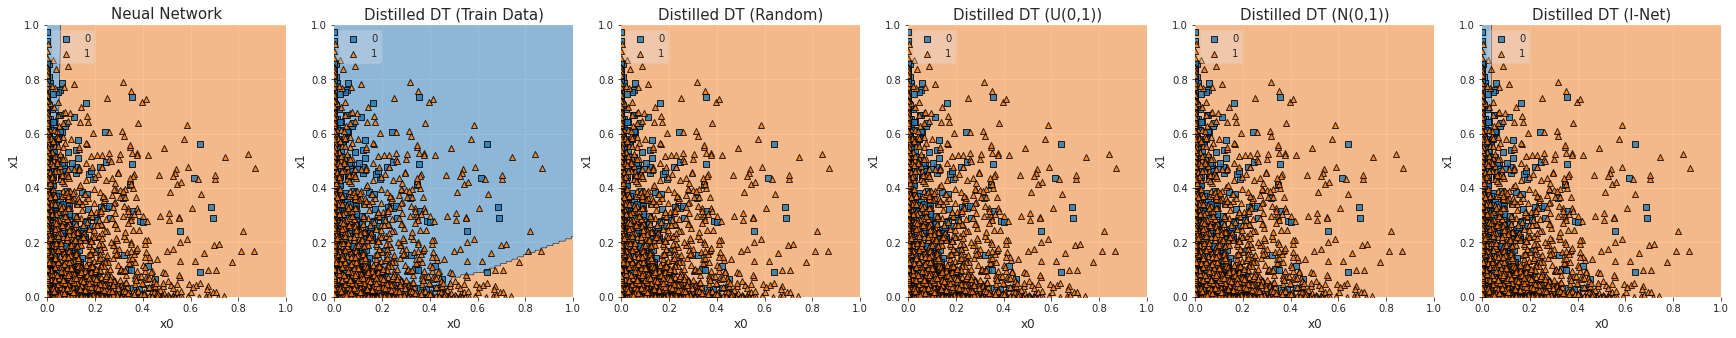

-----------------------------------------------------
Index:  72
Feature 1:  Samples 4569 / 431
	 Distribution 1: beta
		 a: 2.86
		 b: 3.863
	 Distribution 2: beta
		 a: 2.578
		 b: 3.05
Feature 2:  Samples 1750 / 3250
	 Distribution 1: uniform
		 low: 2.491
		 high: 3.095
	 Distribution 2: uniform
		 low: 3.606
		 high: 3.824
Considered Columns:								 0   1
Performance Network:								 0.862
Fidelity DT Sklearn Train Data:							 0.714
Fidelity DT Distilled (['uniform', 'normal', 'gamma', 'beta', 'poisson']):   	 0.388
Fidelity DT Sklearn Uniform Data:						 0.388
Fidelity DT Sklearn Normal Data:						 0.388
Fidelity DT I-Net:								 1.0


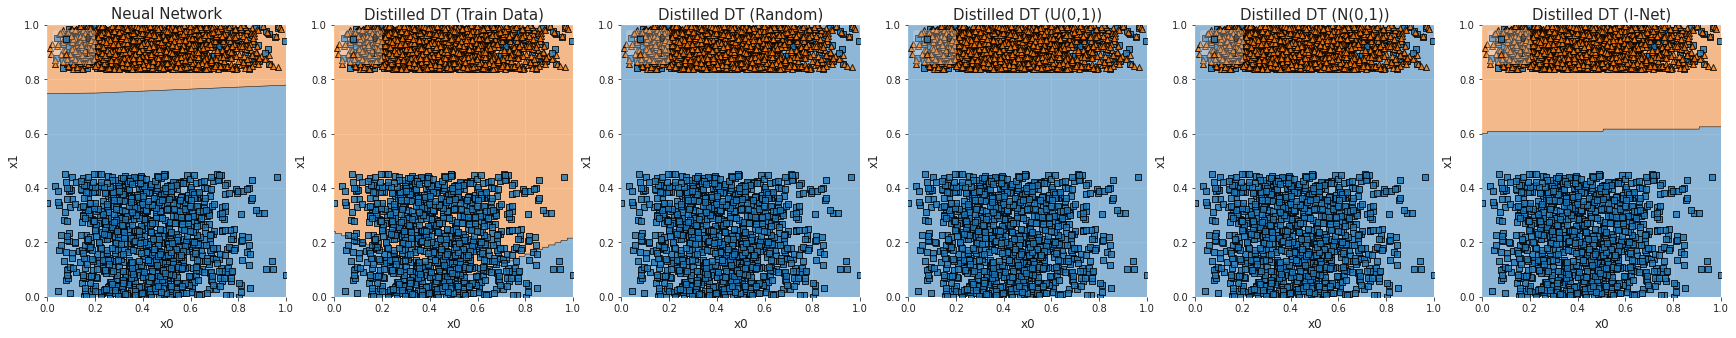

-----------------------------------------------------
Index:  184
Feature 1:  Samples 437 / 4563
	 Distribution 1: uniform
		 low: 0.653
		 high: 2.575
	 Distribution 2: uniform
		 low: 0.365
		 high: 1.201
Feature 2:  Samples 4080 / 920
	 Distribution 1: poisson
		 lam: 3.15
	 Distribution 2: poisson
		 lam: 2.776
Considered Columns:								 0   1
Performance Network:								 0.536
Fidelity DT Sklearn Train Data:							 0.87
Fidelity DT Distilled (['uniform', 'normal', 'gamma', 'beta', 'poisson']):   	 0.418
Fidelity DT Sklearn Uniform Data:						 0.418
Fidelity DT Sklearn Normal Data:						 0.142
Fidelity DT I-Net:								 0.936


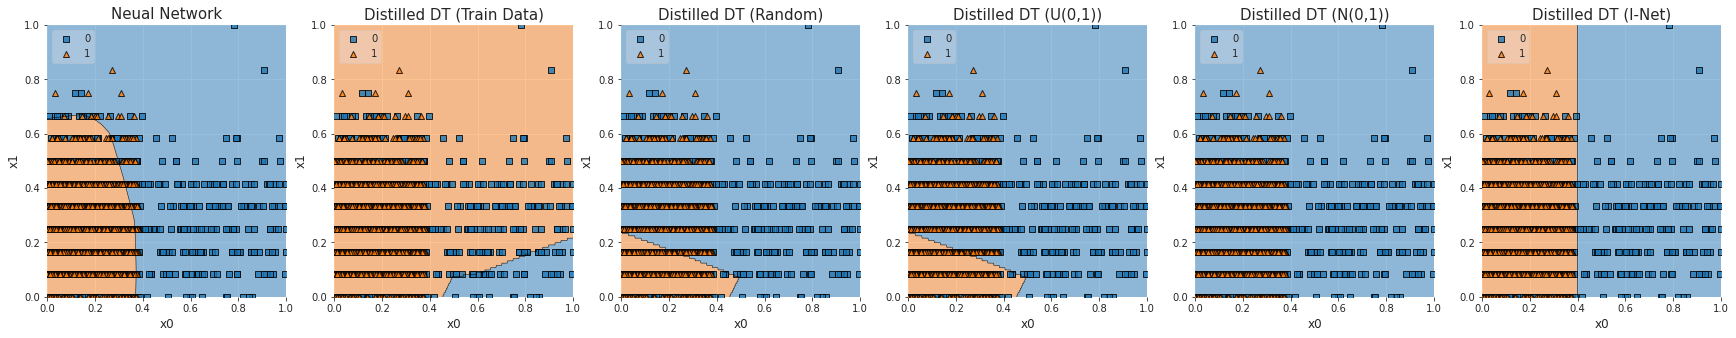

-----------------------------------------------------
Index:  349
Feature 1:  Samples 3064 / 1936
	 Distribution 1: gamma
		 shape: 3.11
		 scale: 0.163
	 Distribution 2: gamma
		 shape: 4.014
		 scale: 2.216
Feature 2:  Samples 3684 / 1316
	 Distribution 1: poisson
		 lam: 2.878
	 Distribution 2: poisson
		 lam: 0.688
Considered Columns:								 0   1
Performance Network:								 0.872
Fidelity DT Sklearn Train Data:							 0.654
Fidelity DT Distilled (['uniform', 'normal', 'gamma', 'beta', 'poisson']):   	 0.346
Fidelity DT Sklearn Uniform Data:						 0.346
Fidelity DT Sklearn Normal Data:						 0.346
Fidelity DT I-Net:								 0.952


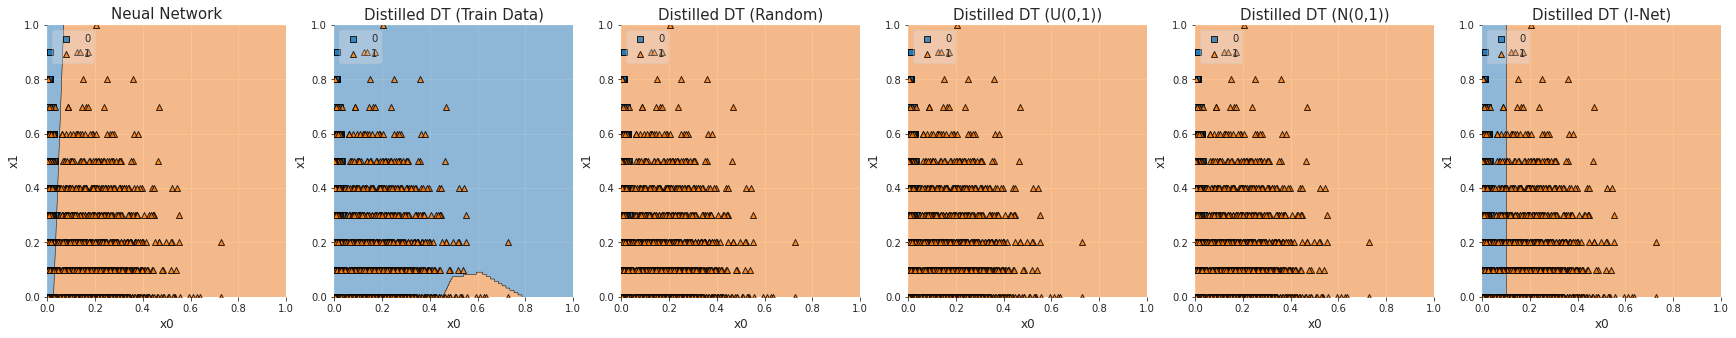

-----------------------------------------------------


In [31]:
if evaluate_distribution:
    timestr = time.strftime("%Y%m%d-%H%M%S")
    identifier_folder = config['function_family']['dt_type'] + '_' + str(config['function_family']['decision_sparsity']) + '_' + timestr
    os.makedirs('./data/distrib_plots/' + identifier_folder + '/', exist_ok=True)
    
    for i in range(min(25, test_size)):
        #index = 14
        #index = np.argmax(np.array(inet_evaluation_result_dict_complete_by_distribution_test['uniform']['inet_scores']['accuracy']) - np.array(inet_evaluation_result_dict_complete_by_distribution_test['uniform']['dt_scores']['accuracy']))
        top_number = i
        #index = np.argsort(np.array(inet_evaluation_result_dict_complete_by_distribution_test['uniform']['inet_scores']['accuracy']) - np.array(inet_evaluation_result_dict_complete_by_distribution_test['uniform']['dt_scores']['accuracy']))[::-1][top_number]

        scores_distilled_median_random = np.median(np.array([inet_evaluation_result_dict_complete_by_distribution_test[str(distrib)]['dt_scores']['accuracy'] for distrib in config['data']['distribution_list_eval']]), axis=0)
        scores_distilled_uniform = inet_evaluation_result_dict_complete_by_distribution_test[str(config['data']['distribution_list_eval'][0])]['dt_scores']['accuracy_uniform_data']
        scores_distilled_normal = inet_evaluation_result_dict_complete_by_distribution_test[str(config['data']['distribution_list_eval'][0])]['dt_scores']['accuracy_normal_data']
        
        scores_distilled_array = np.mean([scores_distilled_median_random, scores_distilled_uniform, scores_distilled_normal], axis=0)
        
        index = np.argsort(np.array(inet_evaluation_result_dict_complete_by_distribution_test[list(inet_evaluation_result_dict_complete_by_distribution_test.keys())[0]]['inet_scores']['accuracy']) - scores_distilled_array)[::-1][top_number]
        #index = np.argsort(np.array(inet_evaluation_result_dict_complete_by_distribution_test['uniform']['inet_scores']['accuracy']) - np.max(np.array([inet_evaluation_result_dict_complete_by_distribution_test[distrib]['dt_scores']['accuracy'] for distrib in config['data']['distribution_list_eval']]), axis=0))[::-1][top_number]
        #index = np.argsort(np.array(inet_evaluation_result_dict_complete_by_distribution_test['uniform']['inet_scores']['accuracy']) - np.mean(np.array([inet_evaluation_result_dict_complete_by_distribution_test[distrib]['dt_scores']['accuracy'] for distrib in config['data']['distribution_list_eval']]), axis=0))[::-1][top_number]

        distrib_for_index = np.argmax(np.array([inet_evaluation_result_dict_complete_by_distribution_test[str(distrib)]['dt_scores']['accuracy'] for distrib in config['data']['distribution_list_eval']])[:,index])

        print('Index: ', index)
        distribution_dict = distribution_parameter_list_list[index]

        print('Feature 1: ', 'Samples', distribution_dict[0][list(distribution_dict[0].keys())[0]]['samples_class_0'], '/', config['data']['lambda_dataset_size']-distribution_dict[0][list(distribution_dict[0].keys())[0]]['samples_class_0'])
        print('\t Distribution 1: ' + list(distribution_dict[0].keys())[0])
        for j, (distrib_parameter_name, distrib_parameter_value) in enumerate(distribution_dict[0][list(distribution_dict[0].keys())[0]]['class_0'].items()):
            print('\t\t '  + distrib_parameter_name +  ': ' + str(np.round(distrib_parameter_value, 3)))
        print('\t Distribution 2: ' + list(distribution_dict[0].keys())[0])
        for j, (distrib_parameter_name, distrib_parameter_value) in enumerate(distribution_dict[0][list(distribution_dict[0].keys())[0]]['class_1'].items()):
            print('\t\t '  + distrib_parameter_name +  ': ' + str(np.round(distrib_parameter_value, 3)))

        print('Feature 2: ', 'Samples', distribution_dict[1][list(distribution_dict[1].keys())[0]]['samples_class_0'], '/', config['data']['lambda_dataset_size']-distribution_dict[1][list(distribution_dict[1].keys())[0]]['samples_class_0'])
        print('\t Distribution 1: ' + list(distribution_dict[1].keys())[0])
        for j, (distrib_parameter_name, distrib_parameter_value) in enumerate(distribution_dict[1][list(distribution_dict[1].keys())[0]]['class_0'].items()):
            print('\t\t '  + distrib_parameter_name +  ': ' + str(np.round(distrib_parameter_value, 3)))
        print('\t Distribution 2: ' + list(distribution_dict[1].keys())[0])
        for j, (distrib_parameter_name, distrib_parameter_value) in enumerate(distribution_dict[1][list(distribution_dict[1].keys())[0]]['class_1'].items()):
            print('\t\t '  + distrib_parameter_name +  ': ' + str(np.round(distrib_parameter_value, 3)))

        identifier_file = 'index' + str(index) + '_' + '_'.join([list(dist.keys())[0] + '_' +  '_'.join([key + '-' + str(np.round(value, 4)) for key, value in dist[list(dist.keys())[0]]['class_0'].items()]) + '_' + '_'.join([key + '-' + str(np.round(value, 4)) for key, value in dist[list(dist.keys())[0]]['class_1'].items()]) for dist in distribution_parameter_list_list[index]])
        
        plot_decision_area_evaluation_all_distrib(data_dict_list_test[index]['X_train'], 
                                            data_dict_list_test[index]['y_train'], 
                                            data_dict_list_test[index]['X_test'], 
                                            data_dict_list_test[index]['y_test'],
                                            None,
                                            None,
                                            network_parameters_to_network(shaped_network_parameters_to_array(test_network_list_distrib[index], config), config),
                                            dt_distilled_list_test[0][index][-3],
                                            dt_distilled_list_test[0][index][-2],
                                            dt_distilled_list_test[0][index][-1],
                                            [dt_distilled_list_test[i][index][0] for i in range(len(config['data']['distribution_list_eval']))],     
                                            dt_inet_list_test[0][index],
                                            np.array([str(i) for i in range(data_dict_list_test[index]['X_train'].shape[1])]),
                                            config['data']['distribution_list_eval'],
                                            config,
                                            identifier_folder = identifier_folder,
                                            identifier_file = identifier_file
                                           )    



I-Net Decision Tree


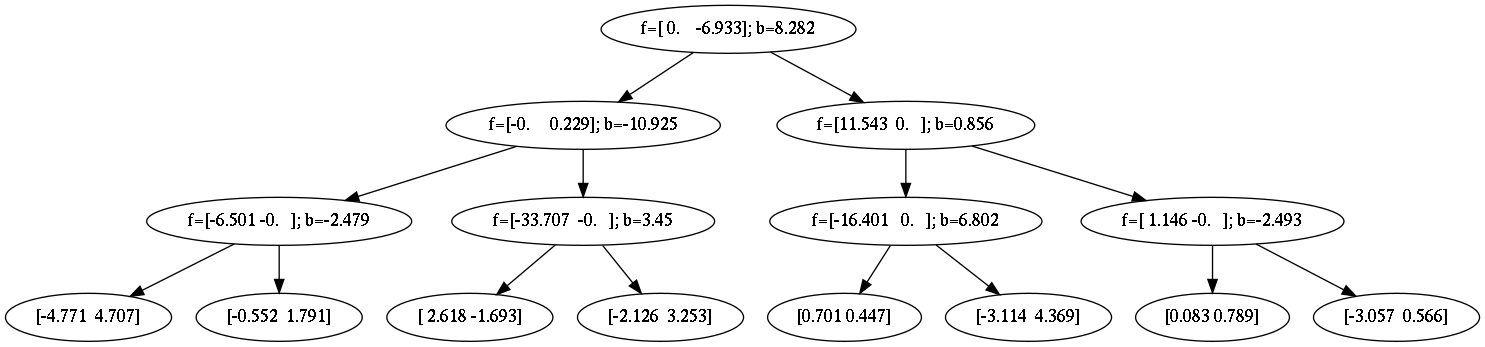

Random Data Decision Tree


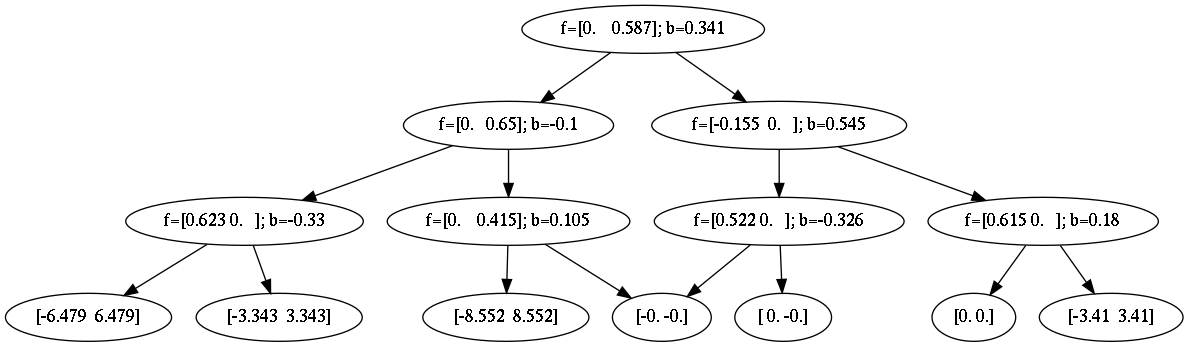

Train Data Decision Tree


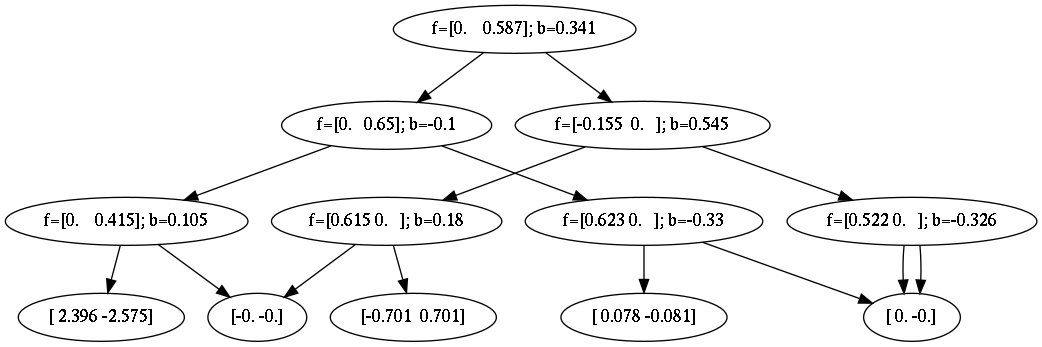

Uniform Data Decision Tree


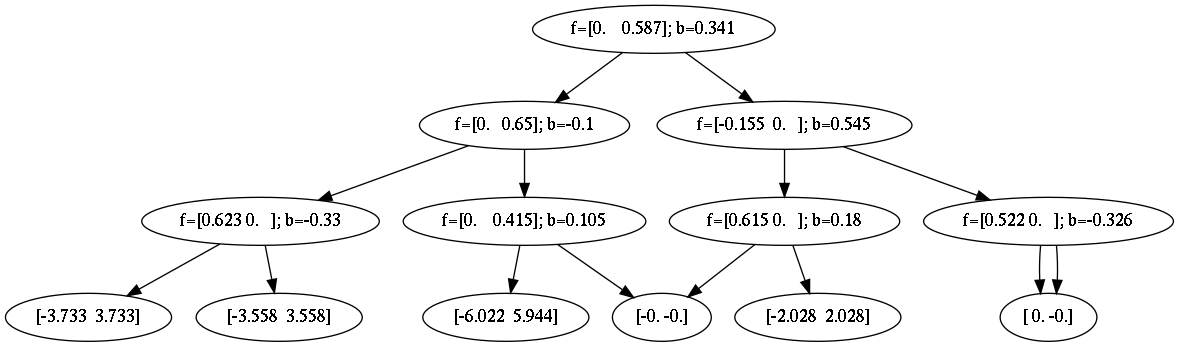

<Figure size 1080x576 with 0 Axes>

<Figure size 1080x576 with 0 Axes>

<Figure size 1080x576 with 0 Axes>

<Figure size 1080x576 with 0 Axes>

In [32]:
if config['function_family']['dt_type'] == 'vanilla':
    print('I-Net Decision Tree')
    plt.figure(figsize=(15,8))
    dt_inet = parameterDT(dt_inet_list_test[distrib_for_index][index], config)
    image = dt_inet.plot()
    display(image)
    
    print('Random Data Decision Tree')
    plt.figure(figsize=(15,8))
    plot_tree(dt_distilled_list_test[distrib_for_index][index][0], fontsize=10)  #fist index=distrib; second index=index; third index=[config['evaluation']['random_evaluation_dataset_size_per_distribution'], 'TRAINDATA', 'STANDARDUNIFORM', 'STANDARDNORMAL']
    plt.show()
    
    print('Train Data Decision Tree')
    plt.figure(figsize=(15,8))
    plot_tree(dt_distilled_list_test[distrib_for_index][index][1], fontsize=10)  #fist index=distrib; second index=index; third index=[config['evaluation']['random_evaluation_dataset_size_per_distribution'], 'TRAINDATA', 'STANDARDUNIFORM', 'STANDARDNORMAL']
    plt.show()    
    
    print('Uniform Data Decision Tree')
    plt.figure(figsize=(15,8))
    plot_tree(dt_distilled_list_test[distrib_for_index][index][2], fontsize=10)  #fist index=distrib; second index=index; third index=[config['evaluation']['random_evaluation_dataset_size_per_distribution'], 'TRAINDATA', 'STANDARDUNIFORM', 'STANDARDNORMAL']
    plt.show()    
else:
    print('I-Net Decision Tree')
    plt.figure(figsize=(15,8))
    dt_parameters = dt_inet_list_test[distrib_for_index][index]
    tree = generate_random_decision_tree(config)
    tree.initialize_from_parameter_array(dt_parameters, reshape=True, config=config)
    image = tree.plot_tree()
    display(image)
    
    print('Random Data Decision Tree')
    plt.figure(figsize=(15,8))
    image = dt_distilled_list_test[distrib_for_index][index][0].plot_tree() #fist index=distrib; second index=index; third index=[config['evaluation']['random_evaluation_dataset_size_per_distribution'], 'TRAINDATA', 'STANDARDUNIFORM', 'STANDARDNORMAL']
    display(image)
    
    print('Train Data Decision Tree')
    plt.figure(figsize=(15,8)) 
    image = dt_distilled_list_test[distrib_for_index][index][1].plot_tree() #fist index=distrib; second index=index; third index=[config['evaluation']['random_evaluation_dataset_size_per_distribution'], 'TRAINDATA', 'STANDARDUNIFORM', 'STANDARDNORMAL'] 
    display(image)
    
    print('Uniform Data Decision Tree')
    plt.figure(figsize=(15,8))
    image = dt_distilled_list_test[distrib_for_index][index][2].plot_tree() #fist index=distrib; second index=index; third index=[config['evaluation']['random_evaluation_dataset_size_per_distribution'], 'TRAINDATA', 'STANDARDUNIFORM', 'STANDARDNORMAL']
    display(image)

In [33]:
if False:
    plot_class_distrib_by_feature(model = model,
                                  index = index,
                                  test_network = network_parameters_to_network(lambda_net_dataset_valid.network_parameters_array[index], config, base_model=None),
                                  distribution_training = config['data']['distribution_list_eval'][distrib_for_index],
                                  distribution_dict = lambda_net_dataset_valid.distribution_dict_list_list[index],
                                  X_test = lambda_net_dataset_valid.X_test_lambda_array[index],
                                  config = config)

In [34]:
if False:
    plot_class_distrib_by_feature(model = model,
                                  index = index,
                                  test_network = network_parameters_to_network(shaped_network_parameters_to_array(test_network_list_distrib[index], config), config, base_model=None),
                                  distribution_training = config['data']['distribution_list_eval'][distrib_for_index],
                                  distribution_dict = lambda_net_dataset_valid.distribution_dict_list_list[index],
                                  X_test =  data_dict_list_test[0]['X_test'],
                                  config = config)

### Distribution Evaluation (Selected Samples)

In [35]:
#%load_ext autoreload
#%autoreload 2
if False:
    evaluate_network_on_distribution_custom_parameters(distribution_name_feature_0 = 'normal',
                                                       distribution_name_feature_1 = 'normal',
                                                       distribution_parameters_0_param_1_feature_0 = 1.188840288782265,
                                                       distribution_parameters_0_param_2_feature_0 = 0.8566173698593895,
                                                       distribution_parameters_1_param_1_feature_0 = 0.8713650102755661,
                                                       distribution_parameters_1_param_2_feature_0 = 1.8484540179178748,
                                                       distribution_parameters_0_param_1_feature_1 = 1.7185974826882278,
                                                       distribution_parameters_0_param_2_feature_1 = 0.5807878500034862,
                                                       distribution_parameters_1_param_1_feature_1 = 0.44369536008631294,
                                                       distribution_parameters_1_param_2_feature_1 = 1.17864258666672,
                                                       inet = model,
                                                       config = config,
                                                       distribution_list_evaluation = config['data']['distribution_list_eval'])


In [36]:
if use_gpu:
    from numba import cuda 
    device = cuda.get_current_device()
    device.reset()